In [2]:
# import required packages
import matplotlib.pyplot as plt
import numpy as np
import json
import seaborn as sns
import pandas as pd
import math

from sympy import *
import itertools
from sklearn.metrics import r2_score,mean_absolute_percentage_error


# the packages for EIS ECMs analysis
import impedance
from impedance import preprocessing
from impedance.validation import linKK


# the packages for peak fitting
import glob
import os
from os.path import basename
from scipy.optimize import curve_fit
import sys

# the packages for bayesian inference
import arviz as az
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS,HMC,HMCECS,BarkerMH,HMCGibbs,DiscreteHMCGibbs

from numpyro.infer import Predictive
from numpyro.infer.util import log_likelihood,log_density

from IPython.display import set_matplotlib_formats
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import jax

import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow_probability.substrates.jax.mcmc import kernel as kernel_base
from tensorflow_probability.python.internal.backend.jax.compat import v2 as tf
import tensorflow_probability as tfp; tfp = tfp.substrates.jax

# the package for storage
import dill

# the package for ignoring warnings
import warnings

# the package for regular expression
import re

# the packages for calling julia file/function in python
# #from julia import Julia

In [3]:
# from julia import Julia
# # j = Julia(runtime = r"/Users/qiuyu/Julia/julia-1.8.3/bin/julia",compiled_modules=False)
# j = Julia(runtime = r"/Users/qiuyu/Julia/julia-1.8.3/bin/julia")


In [4]:
# ignore the warning
warnings.filterwarnings('ignore')

In [5]:
# set the parameters for plots
plt.rcParams['figure.figsize']=(19.6, 10.8)

In [6]:
# set the parameters for plots
az.style.use("arviz-darkgrid")

In [7]:
def load_data(data_path):
    
    """ Load the required EIS data(impedance and frequency) from a given data path
        
        Parameter
        ---------
        data_path: str
            the data path of the given EIS data
        
        Returns
        --------
        df: pd.DataFrame
            the dataframe of the given EIS data
    """
    
    data = data_path
    f = open(data)
    if data.endswith(".json"):
        data = json.load(f)
        df = pd.DataFrame(data)
    elif data.endswith(".csv"):
        df = pd.read_csv(f)
    elif data.endswith(".txt"):
        with open("data", "r", encoding="utf-8") as f:
            data = f.read().splitlines()
        # ! modification required
    elif data.endswith(".xlsx"):
        df = pd.read_excel(data)
    return df

In [8]:
def plot_EIS(freq,impedance = "",reals = "",imags = "", kind = 'Nyquist'):
    
    """ Plot impedance data as nyquist plot and bode plots using matplotlib
    
        Parameters
        ----------
        freq: np.array of floats
            the frequencies of EIS data points
            
        impedance: np.array of complex numbers
            the impedance data
            
        reals: np.array of floats
            the real part of the impedance data
            
        imags: np.array of floats
            the imag part of the impedance data
            
        kind: string 
            the kind of plots, can be either Nyquist or Bode
            
        Returns
        ----------
        No returns
    """
    
    
    # plot the Nyquist plot
    if kind == 'Nyquist':
        if impedance != "":
            reals = impedance.real
            imags = impedance.imag
        frequencies = freq
        
        #Set plotting parameters for the data
        fig,axes = plt.subplots(1,3,figsize=(15,3.5),dpi=300)

        axes[0].scatter(reals,-imags,s=1.5)
        axes[0].set_xlabel(r'$Re(Z) / \Omega$')
        axes[0].set_ylabel(r'$-Im(Z) / \Omega$')
        axes[0].set_title('Nyquist plot')

        axes[1].scatter(freq,reals,s=1.5)
        axes[1].set_xscale('log')
        axes[1].set_xlabel('freq (Hz)')
        axes[1].set_ylabel(r'$Re(Z) / \Omega$')
        axes[1].set_title('Bode plot - real part')

        axes[2].scatter(freq,-imags,s=1.5)
        axes[2].set_xscale('log')
        axes[2].set_ylabel(r'$-Im(Z) / \Omega$')
        axes[2].set_xlabel('freq (Hz)')
        axes[2].set_title('Bode plot - imaginary part')
        plt.show()
    
    # plot the Bode plot
    elif kind == 'Bode':
        if impedance != "":
            reals = impedance.real
            imags = impedance.imag
        frequencies = freq

        # Calculate the magnitude and phase of the impedance data
        magnitude = (reals**2 + imags**2)**(1/2)
        phase = np.arctan(imags/reals)
        
        # Set plotting parameters for the data
        fig,ax = plt.subplots(figsize=(5,3.5),dpi=300)

        # plot the magnitude plot
        ax.scatter(np.log10(frequencies),magnitude,c ='b',label='Magnitude')
        ax.set_xlabel("log(freq)")
        ax.set_ylabel("Magnitude")
        ax.set_title('Bode plot')
        # plot the phase plot
        ax2 = ax.twinx()
        ax2.scatter(np.log10(frequencies),phase,c='r', alpha = 0.7,marker='v',label = 'phase')
        ax2.set_ylabel('Phase')
        fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
        fig.show()

In [9]:
def find_ohmic_resistance(reals,imags,save=True):
    
    """ Extract the ohmic resistance of impedance data by doing a 5th order polynomial fit (with 0.05 buffer accuracy)
        
        Parameters:
        ----------
        reals: np.array of floats
            the real part of the impedance data
            
        imags: np.array of floats
            the imag part of the impedance data
            
        Return:
        -------
        ohmic_resistance: float
            the ohmic resistance of impedance data
    """
    
    z = np.polyfit(reals[0:10],imags[0:10],5)
    fz = np.poly1d(z)
    x = symbols('x')
    ohmic_r_set = np.array(list(solveset(fz(x),x,domain=S.Reals)))
    pos = np.where(-imags >= 0 )
    index, = np.where(abs(imags[pos]) == abs(imags[pos]).min()) #finds minimum phase value, note returns as a tuple
    ####################
    print(ohmic_r_set)
    #####################
    ohmic_resistance = ohmic_r_set[np.where(ohmic_r_set < reals[pos][index]*1.05)].max()
    if save:
        with open(f'{data_path}_ohmic_resistance.txt','w') as f:
            f.write(f"ohmic resistance = {ohmic_resistance}")
    return ohmic_resistance

In [10]:
def pre_processing(impedance,freq,threshold):
    
    """ Pre-process impedance data by deleting data with positive imaginary part at high-freq range, and by kk validation
        
        Parameters:
        ----------
        impedance: np.array of complex numbers
            the impedance data
            
        freq: np.array of float
            the frequencies of EIS data points
            
        threshold: float
            the parameter that controls the filtering effect of KK validation
            
        Returns:
        --------
        Zdf_mask: pd.DataFrame with 3 columns
            the impedance data after pre-processing
            
        ohmic_resistance: float
            the ohmic resistance of impedance data
    """
    
    # set plotting params and data directory
    tick_size = 9
    label_size = 11

    plt.rcParams['font.family'] = 'serif'
    plt.rcParams["mathtext.fontset"] = "dejavuserif"
    plt.rcParams['xtick.labelsize'] = tick_size
    plt.rcParams['ytick.labelsize'] = tick_size
    plt.rcParams['axes.labelsize'] = label_size
    plt.rcParams['legend.fontsize'] = tick_size - 1
    
    # load the data
    Re_Z = impedance.real
    Im_Z = impedance.imag
    # Set plotting parameters for the non-filtered data
    fig,axes = plt.subplots(1,3,figsize=(15,3.5),dpi=300)
    
    # Plot the non-filtered plots
    axes[0].scatter(Re_Z,-Im_Z,s=1.5)
    axes[0].set_xlabel(r'$Re(Z) / \Omega$')
    axes[0].set_ylabel(r'$-Im(Z) / \Omega$')
    axes[0].set_title('Non-filtered')
    axes[1].scatter(freq,Re_Z,s=1.5)
    axes[1].set_xscale('log')
    axes[1].set_xlabel('freq (Hz)')
    axes[1].set_ylabel(r'$Re(Z) / \Omega$')
    axes[1].set_title('Non-filtered')
    axes[2].scatter(freq,-Im_Z,s=1.5)
    axes[2].set_xscale('log')
    axes[2].set_ylabel(r'$-Im(Z) / \Omega$')
    axes[2].set_xlabel('freq (Hz)')
    axes[2].set_title('Non-filtered')
    plt.savefig(f'Non-filtered_Nyquist and Bode plots.png', dpi=300)
    plt.show()

    ### FILTER 1 - High Frequency Region
    ### Find index where phase_Zwe == minimum, remove all high frequency values below zero
    # find index: 1khz - 100khz
    
    pos = np.where((1000<= freq)&(freq<= 1000000))
    index, = np.where(abs(Im_Z[pos]) == abs(Im_Z[pos]).min()) #finds minimum phase value, note returns as a tuple
    mask_phase = [True]*len(Im_Z)
    for i in range(len(Im_Z)):
        if i < index:
            mask_phase[i] = False

    freq = freq[index[0]:]
    Z = impedance[index[0]:]
    Re_Z = Re_Z[index[0]:]
    Im_Z = Im_Z[index[0]:]
    
    
    # Filter 1.2 delete all impedance points with negative real impedance
    pos2 = np.where(Re_Z>0)
    freq = freq[pos2]
    Re_Z = Re_Z[pos2]
    Im_Z = Im_Z[pos2]
    Z = Z[pos2]
    
    ### FILTER 2 - Low Frequency Region
    ### Lin-KK data validation to remove 'noisy' data
    ### For Lin-KK, the residuals of Re(Z) and Im(Z) are what will be used as a filter. I have found based on the data set that
    ### somewhere ~0.05% works the best
    M, mu, Z_linKK, res_real, res_imag = linKK(freq, Z, c=.5, max_M=100, fit_type='complex', add_cap=True)

    # Calculate RMSE
    RMSE_value = RMSE_calculator(Z, res_real+res_imag)
        
    # Plot residuals of Lin-KK for visualization purposes. 
    plt.plot(freq, res_imag, label = 'delta Im')
    plt.plot(freq, res_real, label = 'delta Re')
    plt.xlabel('freq (Hz)')
    plt.ylabel('Delta %')
    plt.xscale('log')
    plt.title('Link-KK Validation')
    plt.legend()
    plt.savefig(f'Link-KK Validation.png', dpi=300)

    
    # Need to set a threshold limit for when to filter out the noisy data of the residuals
    # threshold = 0.05 # USER DEFINE!!!

    mask = [False]*(len(res_imag))
    for i in range(len(res_imag)):
        if res_imag[i] < threshold:
            mask[i] = True
        else:
            break

    freq_mask = freq[mask]
    Z_mask = Z[mask]
    Re_Z_mask = Re_Z[mask]
    Im_Z_mask = Im_Z[mask]
    
    # find the ohmic resistance
    ohmic_resistance = find_ohmic_resistance(Re_Z_mask,Im_Z_mask)
    print(f"ohmic_resistance = {ohmic_resistance}")

    #Putting into a dataframe for use with plotting and program
    values_mask = np.array([freq_mask,Re_Z_mask,Im_Z_mask])
    labels = ['freq','Zreal','Zimag']
    Zdf_mask = pd.DataFrame(values_mask.transpose(), columns = labels)
    
    # Plot the data to see how the filter performed
    fig,axes = plt.subplots(1,3,figsize=(15,3.5),dpi=300)
    axes[0].scatter(Zdf_mask['Zreal'].values,-Zdf_mask['Zimag'].values,s=1.5)
    #if index == 0:
    #    axes[0].scatter(Re_Z_mask, fz(Re_Z_mask),s=1.5,c='r')
    axes[0].set_xlabel(r'$Re(Z) / \Omega$')
    axes[0].set_ylabel(r'$-Im(Z) / \Omega$')
    axes[0].set_title('Nyquist Plot')
    axes[1].scatter(Zdf_mask['freq'].values,Zdf_mask['Zreal'].values,s=1.5)
    axes[1].set_xscale('log')
    axes[1].set_xlabel('freq (Hz)')
    axes[1].set_ylabel(r'$Re(Z) / \Omega$')
    axes[1].set_title('Bode plot - Real part')
    axes[2].scatter(Zdf_mask['freq'].values,-Zdf_mask['Zimag'].values,s=1.5)
    axes[2].set_xscale('log')
    axes[2].set_ylabel(r'$-Im(Z) / \Omega$')
    axes[2].set_xlabel('freq (Hz)')
    axes[2].set_title('Bode plot - Imaginary Part')
    plt.savefig(f'Filtered_Nyquist and Bode plots.png', dpi=300)
    plt.show()
    
    return Zdf_mask,ohmic_resistance,RMSE_value


In [11]:
def pre_processing_kk(impedance,freq,threshold):
    
    """ Pre-process impedance data by deleting data with positive imaginary part at high-freq range, and by kk validation
        
        Parameters:
        ----------
        impedance: np.array of complex numbers
            the impedance data
            
        freq: np.array of float
            the frequencies of EIS data points
            
        threshold: float
            the parameter that controls the filtering effect of KK validation
            
        Returns:
        --------
        Zdf_mask: pd.DataFrame with 3 columns
            the impedance data after pre-processing
            
        ohmic_resistance: float
            the ohmic resistance of impedance data
    """
    
    # set plotting params and data directory
    tick_size = 9
    label_size = 11

    plt.rcParams['font.family'] = 'serif'
    plt.rcParams["mathtext.fontset"] = "dejavuserif"
    plt.rcParams['xtick.labelsize'] = tick_size
    plt.rcParams['ytick.labelsize'] = tick_size
    plt.rcParams['axes.labelsize'] = label_size
    plt.rcParams['legend.fontsize'] = tick_size - 1
    
    # load the data
    Re_Z = impedance.real
    Im_Z = impedance.imag
    Z = impedance

    # Set plotting parameters for the non-filtered data
    fig,axes = plt.subplots(1,3,figsize=(15,3.5),dpi=300)
    
    # Plot the non-filtered plots
    axes[0].scatter(Re_Z,-Im_Z,s=1.5)
    axes[0].set_xlabel(r'$Re(Z) / \Omega$')
    axes[0].set_ylabel(r'$-Im(Z) / \Omega$')
    axes[0].set_title('Non-filtered')
    axes[1].scatter(freq,Re_Z,s=1.5)
    axes[1].set_xscale('log')
    axes[1].set_xlabel('freq (Hz)')
    axes[1].set_ylabel(r'$Re(Z) / \Omega$')
    axes[1].set_title('Non-filtered')
    axes[2].scatter(freq,-Im_Z,s=1.5)
    axes[2].set_xscale('log')
    axes[2].set_ylabel(r'$-Im(Z) / \Omega$')
    axes[2].set_xlabel('freq (Hz)')
    axes[2].set_title('Non-filtered')
    plt.savefig(f'Non-filtered_Nyquist and Bode plots.png', dpi=300)
    plt.show()

    # Filter 1.2 delete all impedance points with negative real impedance
    pos2 = np.where(Re_Z>0)
    freq = freq[pos2]
    Re_Z = Re_Z[pos2]
    Im_Z = Im_Z[pos2]
    Z = Z[pos2]
    
    ### FILTER 2 - Low Frequency Region
    ### Lin-KK data validation to remove 'noisy' data
    ### For Lin-KK, the residuals of Re(Z) and Im(Z) are what will be used as a filter. I have found based on the data set that
    ### somewhere ~0.05% works the best
    M, mu, Z_linKK, res_real, res_imag = linKK(freq, Z, c=.5, max_M=100, fit_type='complex', add_cap=True)

    # Calculate RMSE
    RMSE_value = RMSE_calculator(Z, res_real+res_imag)
        
    # Plot residuals of Lin-KK for visualization purposes. 
    plt.plot(freq, res_imag, label = 'delta Im')
    plt.plot(freq, res_real, label = 'delta Re')
    plt.xlabel('freq (Hz)')
    plt.ylabel('Delta %')
    plt.xscale('log')
    plt.title('Link-KK Validation')
    plt.legend()
    plt.savefig(f'Link-KK Validation.png', dpi=300)

    
    # Need to set a threshold limit for when to filter out the noisy data of the residuals
    # threshold = 0.05 # USER DEFINE!!!

    mask = [False]*(len(res_imag))
    for i in range(len(res_imag)):
        if res_imag[i] < threshold:
            mask[i] = True
        else:
            break

    freq_mask = freq[mask]
    Z_mask = Z[mask]
    Re_Z_mask = Re_Z[mask]
    Im_Z_mask = Im_Z[mask]
    
    # find the ohmic resistance
    ohmic_resistance = find_ohmic_resistance(Re_Z_mask,Im_Z_mask)
    print(f"ohmic_resistance = {ohmic_resistance}")

    #Putting into a dataframe for use with plotting and program
    values_mask = np.array([freq_mask,Re_Z_mask,Im_Z_mask])
    labels = ['freq','Zreal','Zimag']
    Zdf_mask = pd.DataFrame(values_mask.transpose(), columns = labels)
    
    # Plot the data to see how the filter performed
    fig,axes = plt.subplots(1,3,figsize=(15,3.5),dpi=300)
    axes[0].scatter(Zdf_mask['Zreal'].values,-Zdf_mask['Zimag'].values,s=1.5)
    #if index == 0:
    #    axes[0].scatter(Re_Z_mask, fz(Re_Z_mask),s=1.5,c='r')
    axes[0].set_xlabel(r'$Re(Z) / \Omega$')
    axes[0].set_ylabel(r'$-Im(Z) / \Omega$')
    axes[0].set_title('Nyquist Plot')
    axes[1].scatter(Zdf_mask['freq'].values,Zdf_mask['Zreal'].values,s=1.5)
    axes[1].set_xscale('log')
    axes[1].set_xlabel('freq (Hz)')
    axes[1].set_ylabel(r'$Re(Z) / \Omega$')
    axes[1].set_title('Bode plot - Real part')
    axes[2].scatter(Zdf_mask['freq'].values,-Zdf_mask['Zimag'].values,s=1.5)
    axes[2].set_xscale('log')
    axes[2].set_ylabel(r'$-Im(Z) / \Omega$')
    axes[2].set_xlabel('freq (Hz)')
    axes[2].set_title('Bode plot - Imaginary Part')
    plt.savefig(f'Filtered_Nyquist and Bode plots.png', dpi=300)
    plt.show()
    
    return Zdf_mask,ohmic_resistance,RMSE_value


In [12]:
def save_processed_data(input_name, data_stored):
    
    """ Store the processed EIS data in a .csv file
        
        Parameters:
        -----------
        input_name: str
            the data path of the given EIS data
            
        data_stored: pd.DataFrame
            the impedance data after pre-processing
        
        Returns:
        --------
        file_name:
            the data path of the processed EIS data
    """
    
    if input_name.endswith(".json"):
        file_name = input_name.split(".json")[0]
    elif input_name.endswith(".csv"):
        file_name = input_name.split(".csv")[0]
    elif input_name.endswith(".txt"):
        file_name = input_name.split(".txt")[0]
    elif input_name.endswith(".xlsx"):
        file_name = input_name.split(".xlsx")[0]
    elif input_name.endswith(".pkl"):
        file_name = input_name.split(".pkl")[0]
    data_stored.to_csv(file_name+'_processed'+".csv",header = None,index=False)
    data_stored.to_csv('temp'+".csv",header = None,index=False)
    return file_name + ".csv"

In [13]:
def load_results(file_path):
    
    """ load the ECMs results generated by the julia program and convert it to pd.DataFrame
        
        Parameters:
        -----------
        file_path: str
            the file path of ECMs results
            
        Returns:
        --------
        df_circuits: pd.DataFrame
            the dataframe that stored ECMs results generated by the julia program (2 columns)
    """
    
    df_circuits = pd.read_csv(file_path)
    return df_circuits

In [14]:
def split_components(df_circuits):
    
    """ Split all the components and their corresponding values of each ECMs
    
        Parameter:
        ---------
        df_circuits: pd.DataFrame
            the dataframe that stored ECMs results generated by the julia program (2 columns)
            
        Return:
        -------
        df_circuits: pd.DataFrame
            the dataframe that stored ECMs results generated by the julia program (6 columns)
    """
    
    # define some regular expression pattern to separate each kind of elements
    resistor_p = re.compile(r'[R][0-9][a-z]? = [0-9]*\.[0-9]*')
    capacitor_p = re.compile(r'[C][0-9][a-z]? = [0-9]*\.[0-9]*')
    inductor_p = re.compile(r'[L][0-9][a-z]? = [0-9]*\.[0-9]*')
    CPE_p = re.compile(r'[P][0-9][a-z]? = [0-9]*\.[0-9]*')

    # initialize some lists to store the values of each kind of elements
    resistors_list = []
    capacitors_list = []
    inductors_list = []
    CPEs_list = []

    for i in range(len(df_circuits['Parameters'])):
        resistors = resistor_p.findall(df_circuits['Parameters'][i])
        capacitors = capacitor_p.findall(df_circuits['Parameters'][i])
        inductors = inductor_p.findall(df_circuits['Parameters'][i])
        CPEs = CPE_p.findall(df_circuits['Parameters'][i])

        resistors_list.append(resistors)
        capacitors_list.append(capacitors)
        inductors_list.append(inductors)
        CPEs_list.append(CPEs)

    df_circuits['Resistors'] = resistors_list
    df_circuits['Capacitors'] = capacitors_list
    df_circuits['Inductors'] = inductors_list
    df_circuits['CPEs'] = CPEs_list
    
    return df_circuits

In [15]:
def capacitance_filter(df_circuits):
    
    """ Filter the circuits by ideal capacitors
        
        Parameter:
        ----------
        df_circuits: pd.DataFrame
           the dataframe that stored ECMs results generated by the julia program (6 columns)
           
        Return:
        -------
        df_circuits: pd.DataFrame
           the dataframe that stored ECMs results (without ideal capacitors) generated by the julia program (6 columns)
    """
    
    for i in range(len(df_circuits['Capacitors'])):
        if df_circuits['Capacitors'][i] != []:
            df_circuits.drop([i],inplace = True)
    df_circuits.reset_index(drop=True,inplace=True)
    return df_circuits

In [16]:
def find_series_elements(circuit):
    
    """ Extract the series componenets existed in the circuit
    
        Parameter:
        ----------
        circuit: str
            the string that stores the configuration of a given circuit
        
        Return:
        -------
        series_circuit: str
            the string that stores the series parts of a given circuit
    """
    
    series_circuit = []
    identifior = 0
    for i in range(len(circuit)):
        if circuit[i] == '[':
            identifior += 1
        if identifior == 0:
            series_circuit.append(circuit[i])
        if circuit[i] == ']':
            identifior -= 1
        # elif identifior != 0:
        #    index_list.append([False])
    series_circuit = ''.join(series_circuit)
    return series_circuit

In [17]:
def ohmic_resistance_filter(df_circuits, ohmic_resistance):
    
    """ Extract the ohmic resistance of each circuit and filter the circuits according to the values (with 15% buffer)
        
        Parameter:
        ----------
        df_circuits: pd.DataFrame
           the dataframe that stored ECMs results (without ideal capacitors) generated by the julia program (6 columns)
        
        ohmic_resistance: float
            the ohmic resistance of the given EIS data
            
        Return:
        -------
        df_circuits: pd.DataFrame
           the dataframe that stored ECMs results (without ideal capacitors/with correct ohmic resistance) generated by the julia program (6 columns)

            
    """
    
    for i in range(len(df_circuits['Circuit'])):
        # find the series elements
        series_circuit = find_series_elements(circuit = df_circuits['Circuit'][i])
        # find the series resistors
        find_R = re.compile(r'R[0-9]')
        series_resistors = find_R.findall(series_circuit)
        # initiate a list to store series resistors' values for future comparison
        R_values_list = []
        for j in range(len(series_resistors)):
            value_R_p = re.compile(f'{series_resistors[j]} = [0-9]*\.[0-9]*')
            values_R_withid = value_R_p.findall(''.join(df_circuits['Resistors'][i]))
            value_R_p2 = re.compile(r'[0-9]*\.[0-9]*')
            for k in range(len(values_R_withid)):
                R_value = value_R_p2.findall(values_R_withid[k])
                R_values_list.append(R_value)
        if R_values_list == []:
            df_circuits.drop([i],inplace = True)
        else:
            value_identify_list = []
            for m in range(len(R_values_list)):
                if float(R_values_list[m][0]) < ohmic_resistance * 0.1 or float(R_values_list[m][0]) > ohmic_resistance * 5:
                    value_identify_list.append(False)
                else:
                    value_identify_list.append(True)
            if True not in value_identify_list:
                df_circuits.drop([i],inplace = True)

    df_circuits.reset_index(drop=True,inplace=True)
    return df_circuits

In [18]:
def series_filter(df_circuits):
    
    """ Filter the circuits by checking if any parallel structure included capacitors
        
        Parameter:
        ----------
        df_circuits: pd.DataFrame
           the dataframe that stored ECMs results generated by the julia program (6 columns)
           
        Return:
        -------
        df_circuits: pd.DataFrame
           the dataframe that stored ECMs results (without ideal capacitors) generated by the julia program (6 columns)
    """
    
    test_pattern = re.compile(r'\[')
    for i in range(len(df_circuits['Circuit'])):
        test_circuit = df_circuits['Circuit'][i]
        if test_pattern.findall(test_circuit) == False:
            df_circuits.drop([i],inplace = True)
    df_circuits.reset_index(drop=True,inplace=True)
    return df_circuits

In [19]:
def generate_mathematical_expression(df_circuits):
    
    """ Generate the mathematical expression of each circuit
        
        Parameter:
        ----------
        df_circuits: pd.DataFrame
           the dataframe that stored ECMs results (without ideal capacitors/with correct ohmic resistance) generated by the julia program (6 columns)
        
        Return:
        -------
        df_circuits: pd.DataFrame
           the dataframe that stored filtered ECMs results with mathematical expressions (7 columns)

    """
    
    # define two kinds of pattern to find all elements in the circuit
    test_pattern = re.compile(r'([CLRP])([0-9]+)+')
    test_pattern_2 = re.compile(r'[CLRP][0-9]+')
    
    # create a list to store the mathematical expressions
    new_circuits = []
    
    for i in range(len(df_circuits['Circuit'])):
        circuit = df_circuits['Circuit'][i]
        for j,k in zip(["-","[",",","]"],["+","((",")**(-1)+(",")**(-1))**(-1)"]):
            circuit = circuit.replace(j,k)
        test_results = test_pattern.findall(circuit)
        test_results_2 = test_pattern_2.findall(circuit)
        
        test_results.reverse()
        test_results_2.reverse()
        
        for m in range(len(test_results)):
            if test_results[m][0] == 'R':
                circuit = circuit.replace(test_results_2[m],"X")
            elif test_results[m][0] == 'C':
                circuit = circuit.replace(test_results_2[m],"(1/(2*1j*np.pi*F*X))")
            elif test_results[m][0] == 'L':
                circuit = circuit.replace(test_results_2[m],"(2*1j*np.pi*F*X)")
            elif test_results[m][0] == 'P':
                circuit = circuit.replace(test_results_2[m],"X*(2*np.pi*F)**(-Y)*(np.cos((np.pi*Y)*0.5)-np.sin((np.pi*X)*0.5)*1j)")
        
        new_temp_circuit = []
        counter = 0
        
        for n in range(len(circuit)):
            if circuit[n] == 'X':
                new_temp_circuit.append(f"X[{str(counter)}]")
                counter += 1
            elif circuit[n] == 'Y':
                new_temp_circuit.append(f"X[{str(counter)}]")
            else:
                new_temp_circuit.append(circuit[n])
        new_circuit = ''.join(new_temp_circuit)
        new_circuits.append(new_circuit)
        

    df_circuits['Mathematical expressions'] = new_circuits
    
    return df_circuits
 

In [20]:
def s_to_a_convert(circuit):
    
    """ Convert the circuit configuration strings to np.array (representing components by numbers)
        
        Parameter:
        ----------
        circuit: str
            the string that stores the circuit configurations
            
        Return:
        -------
        circuit_array: np.array
            the nparray that stores the circuit configurations
    """
    
    # delete the numbers included in str
    circuit = re.sub(r'[0-9]+', '', circuit)
    pat = re.compile(r'[RCLP\[\]\-,]')
    str = pat.findall(circuit)
    circuit_array = np.zeros((1,len(str)))
    for i in range(len(str)):
        # encoding rules: R=1，C=2，L=3，P=4，[=5,]=6,"-"=7,","=8
        if str[i] == "R":
            circuit_array[0,i] = 1
        elif str[i] == "C":
            circuit_array[0,i] = 2
        elif str[i] == "L":
            circuit_array[0,i] = 3
        elif str[i] == "P":
            circuit_array[0,i] = 4
        elif str[i] == "[":
            circuit_array[0,i] = 5
        elif str[i] == "]":
            circuit_array[0,i] = 6
        elif str[i] == "-":
            circuit_array[0,i] = 7
        elif str[i] == ",":
            circuit_array[0,i] = 8
    return circuit_array[0]

In [21]:
def count_components(circuit,symbols = True):
    
    """ Calculate the numbers of each kind of component in given circuit strings (R/C/L/P/-/,/[/])
        
        Parameters:
        -----------
        circuit: str
            the string that stores the circuit configurations
            
        symbols: bool
            the bool number that decides whether to count the number of connectors in given circuit strings (-/,/[/])
            
        Return:
        -------
        array_components_numbers:np.array
            the array that stores the number of each kind of component 

    """
    
    # define the pattern for each components (p denotes pattern)
    r_p = re.compile(r'[R]')
    c_p = re.compile(r'[C]')
    l_p = re.compile(r'[L]')
    p_p = re.compile(r'[P]')
    if symbols:
        b_p = re.compile(r'[\[\]]')
        d_p = re.compile(r'[\-]')
        comma_p = re.compile(r'[,]')
    
    # find the individual components (n denotes number)
    r_n = r_p.findall(circuit) 
    c_n = c_p.findall(circuit)
    l_n = l_p.findall(circuit)
    p_n = p_p.findall(circuit)
    if symbols:
        b_n = b_p.findall(circuit)
        d_n = d_p.findall(circuit)
        comma_n = comma_p.findall(circuit)
    
    # create array to store the numbers of components
    if symbols:
        array_components_numbers = np.zeros((1,7))
    else:
        array_components_numbers = np.zeros((1,4))
        
    # store the numbers of components into array
    array_components_numbers[0,0] = len(r_n)
    array_components_numbers[0,1] = len(c_n)
    array_components_numbers[0,2] = len(l_n)
    array_components_numbers[0,3] = len(p_n)
    if symbols:
        array_components_numbers[0,4] = len(b_n) # /2 can be used to find the number of separated parallel structure
        array_components_numbers[0,5] = len(d_n)
        array_components_numbers[0,6] = len(comma_n) # add this number with the number of separated parallel sturcture can get the number of subcircuits 
        
    return array_components_numbers[0]

In [22]:
def rank_the_structure(circuit_array):
    
    """ Rank each component in given circuits according to its 'complexity' (defined by how many parallel structures it's in)
    
        Parameter:
        ----------
        circuit_array: np.array
            the nparray that stores the circuit configurations
        
        Return:
        -------
        ranks_array: np.array
            the nparray that stores the level information of given circuits
    """
    
    ranks_array = np.zeros([1,len(circuit_array)])
    ranker = 0
    for i in range(len(circuit_array)):
        if circuit_array[i] == 5:
            ranker += 1
            # -1: [
            ranks_array[0,i]= -1 
        # elif circuit_array[i] == 8:
        #    ranker += 0.5
        #    ranks_store[0,i] = -3
            # -3: ,
        elif circuit_array[i] == 6:
            ranker -= 1
            ranks_array[0,i] = -2
        else:
            ranks_array[0,i] = ranker
    return ranks_array[0]

In [23]:
def structure_deconstructor(ranks_array):
    
    """ Extract the index information of each level circuit according to ranking array
        
        Parameter:
        ----------
        ranks_array:np.array
            the nparray that stores the level information of given circuits
        
        Return:
        -------
        indexs_lists: list
            the list that stores the index information of each level circuit
    """

    # initialize a list to store the indexs 
    indexs_list = []
    # initialize a list to store the index lists
    indexs_lists = []
    for i in range(len(ranks_array)):
        if ranks_array[i] < 0:
            indexs_lists.append(indexs_list)
            indexs_list = []
        elif ranks_array[i] >= 1:
            indexs_list.append(i)
    indexs_lists = [x for x in indexs_lists if x != []]
    return indexs_lists

In [24]:
def structure_extractor(circuit_array,ranks_array, indexs_lists):
    
    """ Extract the circuit configuration at each level
        
        Parameters:
        -----------
        circuit_array: np.array
            the nparray that stores the circuit configurations
            
        ranks_array:np.array
            the nparray that stores the level information of given circuits
            
        indexs_lists: list
            the list that stores the index information of each level circuit
            
        Return:
        -------
        characteristic_array: np.array
            the nparray that stores the circuit configuration separated at different levels 
    """
    
    characteristic_array = np.zeros([len(indexs_lists),max(len(index) for index in indexs_lists)+1])
    for i in range(len(indexs_lists)):
        if ranks_array[indexs_lists[i][0]] == 1:
            characteristic_array[i][0] = 1
        elif ranks_array[indexs_lists[i][0]] == 2:
            characteristic_array[i][0] = 2
        elif ranks_array[indexs_lists[i][0]] == 3:
            characteristic_array[i][0] = 3
        elif ranks_array[indexs_lists[i][0]] == 4:
            characteristic_array[i][0] = 4
        elif ranks_array[indexs_lists[i][0]] == 5:
            characteristic_array[i][0] = 5
        else:
            assert ("Error:Circuit's too complex")
            
        segment = np.array(sorted(circuit_array[indexs_lists[i]]))
        characteristic_array[i][1:1+len(segment)] = segment.reshape(1,len(segment))

    sort_list = [characteristic_array[:,i] for i in range(characteristic_array.shape[1])]
    idex = np.lexsort(sort_list)
    
    characteristic_array = characteristic_array[idex,:]
    
    return characteristic_array

In [25]:
def precise_rank_the_structure(circuit_array):
    
    """ Rank each component in given circuits according to its 'complexity' in a more precise way (defined by how many parallel structures it's in)
    
        Parameter:
        ----------
        circuit_array: np.array
            the nparray that stores the circuit configurations
        
        Return:
        -------
        ranks_array: np.array
            the nparray that stores the level information of given circuits
    """
    
    ranks_array = np.zeros([1,len(circuit_array)])
    ranker = 0
    for i in range(len(circuit_array)):
        if circuit_array[i] == 5:
            ranker += 1
            ranker = int(ranker)
            # -1: [
            ranks_array[0,i]= ranker 
        elif circuit_array[i] == 8:
            ranker += 0.1
            # -3: ,
            ranks_array[0,i] = ranker
        elif circuit_array[i] == 6:
            ranker -= 1
            ranker = int(ranker)
            # -2 : ]
            ranks_array[0,i] = ranker
        else:
            ranks_array[0,i] = ranker
    return ranks_array[0]

In [26]:
def precise_extractor(circuit_array,precise_ranks_array):
    
    """ Extract the index information of each level circuit according to ranking array in a more precise way
        
        Parameter:
        ----------
        circuit_array: np.array
            the nparray that stores the circuit configuration
            
        precise_ranks_array:np.array
            the nparray that stores the level information of given circuits
        
        Return:
        -------
        level_lists: list
            the list that stores the index information of each level circuit
    """
    
    level_lists = []
    if circuit_array[0] == 5:
        # detect [
        # print(1,0)
        level_list = []
        level_list.append(int(precise_ranks_array[0]))
        for j in range(0,len(precise_ranks_array)-1):
            if precise_ranks_array[j] > int(precise_ranks_array[j]) and int(precise_ranks_array[j]) == precise_ranks_array[0]:
                # print("1 end:",j)
                level_list.extend(z for z in circuit_array[0+1:j])
                level_lists.append(level_list)
                break
    for i in range(len(precise_ranks_array)-1):
        if int(precise_ranks_array[i+1]) - int(precise_ranks_array[i]) == 1:
            # detect[ 
            # print(1,i)
            level_list = []
            level_list.append(int(precise_ranks_array[i+1]))
            for j in range(i,len(precise_ranks_array)-1):
                if precise_ranks_array[j] > int(precise_ranks_array[j]) and int(precise_ranks_array[j]) == precise_ranks_array[i+1]:
                    # print("1 end:",j)
                    level_list.extend(z for z in circuit_array[i+2:j])
                    level_lists.append(level_list)
                    break
        elif round(precise_ranks_array[i+1] - precise_ranks_array[i],1) == 0.1:
            # detect ","
            # print(2,i)
            level_list = []
            level_list.append(int(precise_ranks_array[i+1]))
            for j in range(i+2,len(precise_ranks_array)):
                if precise_ranks_array[j] > precise_ranks_array[j-1] and int(precise_ranks_array[j]) == int(precise_ranks_array[j-1]) and int(precise_ranks_array[j]) == int(precise_ranks_array[i+1])or precise_ranks_array[j] == int(precise_ranks_array[i]-1):
                    # print("2 end:", j)
                    level_list.extend(z for z in circuit_array[i+2:j])
                    level_lists.append(level_list)
                    break
    return level_lists



In [27]:
def sort_level_lists(level_lists):
    
    """ Sort the level lists:
    
        Parameter:
        ----------
        level_lists:
            the list that stores the index information of each level circuit
            
        Return:
        -------
        level_lists:
            the sorted list that stores the index information of each level circuit

    """
    
    for i in range(len(level_lists)):
        level_lists[i] = sorted(level_lists[i])
    level_lists = sorted(level_lists)
    return level_lists

In [28]:
def feature_store(circuit):
    
    """ Extract the features of given circuits and store them as a dictionary
            Feature 1: the component numbers (R/C/L/P/-/,/[/]) of a given circuit
            Feature 2: the component numbers in series part of a given circuit
            Feature 2.5: the parallel parts of a given circuit at different levels
            Feature 3: the information of all parallel subcircuits
            
        Parameter:
        ----------
        circuit: str
            the string that stores the circuit configuration
            
        Return:
        -------
        characteristic_features: dict
            the dictionary that stores the above 4 characteristics of a given circuit
    """
    
    circuit = circuit
    circuit_array = s_to_a_convert(circuit)
    ranks_array = rank_the_structure(circuit_array)
    indexs_lists = structure_deconstructor(ranks_array)
    precise_ranks_array = precise_rank_the_structure(circuit_array)
    test_pattern = re.compile(r'\[')

    
    # features 1 - the numbers of each kind of element are equal
    components_numbers = count_components(circuit)
    # feature 2 - same series configurations
    series_numbers = count_components(find_series_elements(circuit))
    if test_pattern.findall(circuit) == True:
        # feature 2.5 - same configurations at different parallel levels
        characteristic_array = structure_extractor(circuit_array,ranks_array,indexs_lists)
        # feature 3 - all parallel subcircuit shoule be identical
        level_lists = precise_extractor(circuit_array,precise_ranks_array)
        level_lists = sort_level_lists(level_lists)
    
    # store the features:
    characteristic_features = {}
    characteristic_features['Circuit_Name'] = circuit
    characteristic_features['Feature 1'] = components_numbers
    characteristic_features['Feature 2'] = series_numbers
    if test_pattern.findall(circuit) == True:
        characteristic_features['Feature 2.5'] = characteristic_array
        characteristic_features['Feature 3'] = level_lists
    
    return characteristic_features

In [29]:
def identifior(df_circuits):
    
    """ Identfy the identical circuits configurations by the above features
        
        Parameter:
        ----------
        df_circuits: pd.DataFrame
           the dataframe that stored filtered ECMs results with mathematical expressions (7 columns)
           
        Returns:
        --------
        equal_lists: list
            the list that stores the strings of identical circuit configurations
            
        equal_lists_seq: list
            the list that stores the index of identical circuits
    """
    equal_lists = []
    equal_lists_seq = []
    for i in range(len(df_circuits['Circuit'])):
        feature_i = feature_store(df_circuits['Circuit'][i])
        equal_list = []
        equal_list_seq = []
        for j in range(len(df_circuits['Circuit'])):
            feature_j = feature_store(df_circuits['Circuit'][j])
            # if (feature_i['Feature 1'] == feature_j['Feature 1']).all() and (feature_i['Feature 2'] == feature_j['Feature 2']).all() and (feature_i['Feature 2.5'] == feature_j['Feature 2.5']).all() and feature_i['Feature 3'] == feature_j['Feature 3']:
            if len(feature_i) == len(feature_j) == 5:
                if feature_i['Feature 1'].tolist() == feature_j['Feature 1'].tolist() and feature_i['Feature 2'].tolist() == feature_j['Feature 2'].tolist() and feature_i['Feature 2.5'].tolist() == feature_j['Feature 2.5'].tolist() and feature_i['Feature 3'] == feature_j['Feature 3']:
                    equal_list.append(df_circuits['Circuit'][j])
                    equal_list_seq.append(j)
            else:
                if feature_i['Feature 1'].tolist() == feature_j['Feature 1'].tolist() and feature_i['Feature 2'].tolist() == feature_j['Feature 2'].tolist():
                    equal_list.append(df_circuits['Circuit'][j])
                    equal_list_seq.append(j)
        equal_lists.append(equal_list)
        equal_lists_seq.append(equal_list_seq)
    return equal_lists, equal_lists_seq  

In [30]:
def filter(similar_circuits):
    
    """ Filter the repeated "identical circuits list" in the list
        
        Parameter:
        ----------
        similar_circuits: list
            the list that stores the index of identical circuits or the strings of identical circuit configurations
        
        Return:
        -------
        equal_list_filtered: list
            the processed list that stores the index of 

    """
    
    similar_circuits.sort()
    equal_list_filtered = list(similar_circuits for similar_circuits,_ in itertools.groupby(similar_circuits))
    return equal_list_filtered

In [31]:
def circuit_expression_combine_lists(df_circuits):
    
        
    """ Identfy the identical circuits configurations by the above features
        
        Parameter:
        ----------
        df_circuits: pd.DataFrame
           the dataframe that stored filtered ECMs results with mathematical expressions (7 columns)
           
        Returns:
        --------
        similar_expression: list
            the processed list that stores the strings of identical circuit configurations
            
        similar_expression_index: list
            the processed list that stores the index of identical circuits
    """
   
    similar_lists = identifior(df_circuits)
    similar_expression = filter(similar_lists[0])
    similar_expression_index = filter(similar_lists[1])
    
    return similar_expression, similar_expression_index


In [32]:
def component_values(input):
    
    """ Before combination, separate the components names and values for further comparison to identify identical circuit values
    
        Parameter:
        ----------
        df_circuits['Parameters']: pd.Series
            the series that stores the names and values information of a given circuit
        
        Returns:
        --------
        component_values_lists: list
            the list that stores the component values and component names
            
        values_lists: list
            the list that only stores the component values
            
        names_lists: list
            the list that only stores the component names
    """
    
    # delete the ( and ) in the string
    delete_p = re.compile(r'[^()]')
    
    # store the values of each component in 4 digits
    digit_p = re.compile(r'\-?[0-9]+\.[0-9]+e*-*[0-9]*')
    
    # store the names of each component
    name_p = re.compile(r'[A-Z][0-9]*[a-z]? = ')
    
    # define a pattern to round the number
    e_p = re.compile(r'e')
    
    # create lists to store these data
    values_lists = []
    component_values_lists =[]
    names_lists =[]
    
    for i in range(len(input)):
        # separate the values of each component and store them with their name together
        # component_values_list = delete_p.findall(input[0])
        # component_values_list = ''.join(component_values_list)
        # component_values_list = component_values_list.split(',')
        # component_values_lists.append(component_values_list)
        
        # store the values of each component
        values_list = digit_p.findall(input[i]) 
        for j in range(len(values_list)):
            if e_p.findall(values_list[j]) == False:
                values_list[j] = "%e"%values_list[j]
            values_list[j] = float(values_list[j])
            # values_list[j] = float(values_list[j])
            values_list[j] = '{:0.4e}'.format(values_list[j])
            values_list[j] = float(values_list[j])
            #values_list[j] = ("%.4f"%values_list[j])
            #values_list[j] = float(values_list[j])
        values_lists.append(values_list)
        
        # store the names of each component
        names_list = name_p.findall(input[i])
        names_lists.append(names_list)
        
        # combine the names with values
        component_values_list=[]
        for k in range(len(values_list)):
            seq = [names_list[k],str(values_list[k])]
            component_values_list.append(''.join(seq))
        component_values_lists.append(component_values_list)
    
    return component_values_lists, values_lists, names_lists

In [33]:
def combine_expression(df_circuits):
    
    """ Combine the identical circuits
        
        Parameter:
        ----------
        df_circuits: pd.DataFrame
           the dataframe that stored filtered ECMs results with mathematical expressions (7 columns)

        Return:
        -------
        df_circuits: pd.DataFrame
           the dataframe that stored filtered ECMs results with mathematical expressions (4 columns)

        
            
    """
    
    combined_expressions = []
    combined_values = []
    mathematical_expressions = []
    counts = []

    similar_expression, similar_expression_index = circuit_expression_combine_lists(df_circuits)
    component_values_lists, values_lists, names_lists= component_values(input=df_circuits['Parameters'])

    for i in range(len(similar_expression_index)):
        combined_expressions.append(df_circuits['Circuit'][similar_expression_index[i][0]])
        combined_value = []
        for j in range(len(similar_expression_index[i])):
            if j == 0:
                combined_value.append(component_values_lists[similar_expression_index[i][j]])
            else:
                if sorted(values_lists[similar_expression_index[i][j]]) != sorted(values_lists[similar_expression_index[i][j-1]]):
                    combined_value.append(component_values_lists[similar_expression_index[i][j]])
                    combined_expressions[i] = [df_circuits['Circuit'][similar_expression_index[i][0]]]
                    combined_expressions[i].append(df_circuits['Circuit'][similar_expression_index[i][j]])
                    # a bug - combined value doesn't correspond to combined expression

        if len(combined_value) > 1:
            # calculate the statistical information about each component
            combined_component_value_list = []
            for k in range(len(combined_value)):
                combined_value_copy = combined_value.copy()
                combined_value_copy[k] = sorted(combined_value[k])
                # ！！！ changed digit

                # digit_p = re.compile(r'\-?[0-9]+\.[0-9]+')
                digit_p = re.compile(r'\-?[0-9]+\.[0-9]+e*-*[0-9]*')
                combined_component_value = digit_p.findall(','.join(combined_value_copy[k]))
                for m in range(len(combined_component_value)):
                    combined_component_value[m] = float(combined_component_value[m])
                combined_component_value_list.append(combined_component_value)
            combined_component_value_array = np.array(combined_component_value_list)

            name_p = re.compile(r'[A-Z][1-9][a-z]? = ')
            combined_name = name_p.findall(','.join(df_circuits['Parameters'][1][0]))

            statistical_info = {"components_name":combined_name,
                                "mean":np.mean(combined_component_value_array,axis=0),
                                "std":np.std(combined_component_value_array,axis=0),
                                "var":np.var(combined_component_value_array,axis=0),
                                "max":np.max(combined_component_value_array,axis=0),
                                "min":np.min(combined_component_value_array,axis=0)}
            combined_value.append(statistical_info)
            # with these statistical info dictionaries, we can easily convert that to a dataframe.
        combined_values.append(combined_value)

        mathematical_expression = df_circuits['Mathematical expressions'][similar_expression_index[i][0]]
        mathematical_expressions.append(mathematical_expression)
        
        # count the freqency of each circuit (?should I use probability here)
        count = len(similar_expression_index[i])
        counts.append(count)
    
    df_list = {'Combined Circuits':combined_expressions, 'Combined Values':combined_values, "Mathematical expressions":mathematical_expressions, "Counts":counts}
    df_circuits = pd.DataFrame(df_list)
    # return df_circuits,values_lists
    return df_circuits


In [34]:
def calculate_length(df_circuits):
    
    """ Cound how many different value sets are in identical circuits
    
        Paramter:
        ---------
        df_circuits: pd.DataFrame
           the dataframe that stored filtered ECMs results with mathematical expressions (4 columns)
           
        Return:
        -------
        df_circuits: pd.DataFrame
           the dataframe that stored filtered ECMs results with mathematical expressions (5 columns)

    """
    
    counts = []
    for i in range(len(df_circuits['Combined Values'])):
        if len(df_circuits['Combined Values'][i])>1:
            count = len(df_circuits['Combined Values'][i]) - 1
            counts.append(count)
        else:
            count = 1
            counts.append(count)

    df_circuits['Different value sets'] = counts
    return df_circuits

In [35]:
def split_variables(df_circuits):
    
    """ Separate the value and name of each component
        
        Parameter:
        ----------
        df_circuits: pd.DataFrame
           the dataframe that stored filtered ECMs results with mathematical expressions (5 columns)
           
        Return:
        -------
        df_circuits: pd.DataFrame
           the dataframe that stored filtered ECMs results with mathematical expressions (7 columns)
    """
    
    # create some lists to store the names and values for BI
    variables_names = []
    variables_values = []
    
    # create some RE pattern to split the values and names
    # digit_p = re.compile(r'\-?[0-9]+\.[0-9]+')
    # ！！！ changed digit
    digit_p = re.compile(r'\-?[0-9]+\.[0-9]+e*-*[0-9]*')

    name_p = re.compile(r'[A-Z][0-9]+[a-z]?')

    for i in range(len(df_circuits['Combined Values'])):
        variables_name = []
        variables_value = []
        if len(df_circuits['Combined Values'][i]) == 1:
            for k in range(len(df_circuits['Combined Values'][i][0])):
                variable = df_circuits['Combined Values'][i][0][k]
                variables_name.append(name_p.findall(variable)[0])
                variables_value.append(float(digit_p.findall(variable)[0]))
        elif len(df_circuits['Combined Values'][i]) != 1: 
            # for j in range(len(df_circuits['Combined Values'][i])-1):
            #  -- pin：different value sets
            for k in range(len(df_circuits['Combined Values'][i][0])):
                variable = df_circuits['Combined Values'][i][0][k]
                variables_name.append(name_p.findall(variable)[0])
                variables_value.append(float(digit_p.findall(variable)[0]))
        variables_names.append(variables_name)
        variables_values.append(variables_value)
    
    df_circuits['Variables_names'] = variables_names
    df_circuits['Variables_values'] = variables_values
    
    df_circuits = df_circuits.reset_index()
    df_circuits.drop(['index'],axis=1,inplace=True)
    
    return df_circuits

In [36]:
def temperate_filter(df):
    
    """ Note: this is just a temporary filtering rule to delete ECMs with 0.0 value after approximation with 4 digits
        
        Parameter:
        ----------
        df: pd.DataFrame
            the dataframe that stores the ECMs after filtering (7 columns)
            
        Return:
        -------
        df: pd.DataFrame
            the dataframe that stores the ECMs after filtering (7 columns)

    """
    
    for i in range(len(df['Combined Circuits'])):
        value_set = df['Variables_values'][i]
        for j in range(len(value_set)):
            if round(value_set[j],12) == 0:
                df = df.drop([i],axis = 0)
                break
    df = df.reset_index()
    df = df.drop(['index'],axis=1)
    return df

In [37]:
def r2_calculator(y_true, y_pred):
    """
    Calculation of the unadjusted r-squared, goodness of fit metric
    """
    sse  = np.square( abs(y_pred - y_true) ).sum()
    sst  = np.square( abs(y_true - y_true.mean()) ).sum()
    return 1 - sse/sst

In [38]:
def MSE_calculator(y_true,y_pred):
    MSE = np.array(((abs(y_true - y_pred))**2)).mean()
    return MSE

In [39]:
def RMSE_calculator(y_true,y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    RMSE = (sum((y_pred.real - y_true.real)**2 + (y_pred.imag - y_true.imag)**2)/len(y_true))**(1/2)
    return RMSE

In [40]:
def MAPE_calculator(y_true,y_pred):
    error_term = abs(y_true - y_pred)
    absolute_error_percentage = error_term/abs(y_true)
    mean_absolute_error_percentage = (100/len(y_true)) * sum(absolute_error_percentage)
    return mean_absolute_error_percentage

In [41]:
def Bayesian_inference(data, df, data_path, n_control = 0.03, plot=True, save=True):
   
    """ Doing the bayesian inference of each circuit
   
        Parameters:
        -----------
        data: pd.DataFrame
            the dataframe that stores data after pre-processing (3 column expected)
            column 1: frequency
            column 2: real part of impedance data
            column 3: imaginary part of impedance data
           
        df: pd.DataFrame
            the dataframe that stores the ECMs after filtering
           
        data_path: str
            the data path of the original EIS data for storage
           
        n_control: float
            the number that controls the prior range of constant phase element
       
        plot: bool
            controls whether to plot or not
           
        save: bool
            controls whether to save data or not
           
        Return:
        -------
        df: pd.DataFrame
            the dataframe that stored ECMs with bayesian inference results (12 columns)
    """
   
    # set the parameters for plots
    az.style.use("arviz-darkgrid")
   
    freq = np.array(data['freq'])
    Zreal = np.array(data['Zreal'])
    Zimag = np.array(data['Zimag'])
   
    amplifying_factor = abs(Zreal.max() - Zreal.min())/abs(Zimag.max()-Zimag.min())
    relative_error_accepted = (((Zreal**2)+(Zimag**2))**(1/2)).mean()
   
    # ohmic_resistance = float(ohmic_resistance)
    # create a list to store the R2 value of each ECM
    R2_list = []
    R2_real_list = []
    R2_imag_list = []
   
    # create a list to store fitting quality metrics of each ECM
    MSE_list = []
    RMSE_list = []
    MAPE_list = []
   
    # create a list to store simulated ECM data
    ECMs_data = []
   
    # create a list to store mean r2 in posteior distribution
    Posterior_r2 = []
    Posterior_r2_real = []
    Posterior_r2_imag = []
   
    # create a list to store mean mse in posteior distribution
#     Posterior_mse = []
#     Posterior_mse_real = []
#     Posterior_mse_imag = []
    Posterior_mape = []
    Posterior_mape_real = []
    Posterior_mape_imag = []
   
    # Start from this source of randomness. We will split keys for subsequent operations.
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)
   
    # BI parts:
    values = df['Variables_values']
    names = df['Variables_names']
    expressions_strs = df['Mathematical expressions']
    circuit_names = df['Combined Circuits']
    num_of_values = df['Combined Values']
    # create lists to store BI results
    models = []
    models_descriptions = []
    Prior_predictions = []
    Posterior_predictions = []
    AIC = []
   

       
    for i in range(len(df['Combined Circuits'])):
        circuit_name_i = circuit_names[i]
        value_i = values[i]
        name_i = names[i]
        expression_str_i = expressions_strs[i].replace("np.","jnp.")
        function_i = eval(f"lambda X,F:{expression_str_i}" )
        
       
        print(f"Circuit {i}:{circuit_name_i} composed of components ({name_i}) with values ({value_i})")
       
        ECM_data = function_i(value_i,freq)
        ECMs_data.append(ECM_data)
       
        print("Julia circuit's fitting")
       
        r2_value = float(r2_calculator(Zreal+1j*Zimag,ECM_data))
        print(f"r2_value:{r2_value}")
        R2_list.append(r2_value)
       
        r2_real = r2_calculator(Zreal,ECM_data.real)
        print(f"r2_real_part:{r2_real}")
        R2_real_list.append(r2_real)
        r2_imag = r2_calculator(Zimag,ECM_data.imag)
        print(f"r2_imag_part:{r2_imag}")
        R2_imag_list.append(r2_imag)
       
        MSE_value = float(MSE_calculator(Zreal+1j*Zimag,ECM_data))
        print(f"MSE_value:{MSE_value}")
        MSE_list.append(MSE_value)
       
        RMSE_value = float(MSE_calculator(Zreal+1j*Zimag,ECM_data)**(1/2))
        print(f"RMSE_value:{RMSE_value}")
        RMSE_list.append(RMSE_value)
       
        MAPE_value = float(MAPE_calculator(Zreal+1j*Zimag,ECM_data)**(1/2))
        print(f"RMSE_value:{MAPE_value}")
        MAPE_list.append(MAPE_value)
       
        if plot:  
            plt.scatter(ECM_data.real,-ECM_data.imag,c='r',s=12,label='Simulated data')
            plt.scatter(Zreal,-Zimag,c='b',s=12,label='Original data')
            plt.xlabel('Real impedance')
            plt.ylabel('- Imag impedance')
            plt.title('Nyquist plots of original data and simulated data')
            plt.legend()
            if save:
                # add a prefix
                plt.savefig(f'Nyquist_plots_of_simulated_data_{circuit_name_i}.png', dpi=300);
            plt.show()

        # def model_i(values=value_i, func=function_i, true_data=data,error = relative_error_accepted,R = ohmic_resistance):
        def model_i(values=value_i, func=function_i, true_data=data,error = relative_error_accepted):

            true_freq = np.asarray(true_data['freq'])
            true_Zreal = np.asarray(true_data['Zreal'])
            true_Zimag = np.asarray(true_data['Zimag'])
           
            variables_list = []
            for j in range(len(name_i)):
                name = name_i[j]
                value = value_i[j]
               
                if 'n' in name:
                    # free_variable = numpyro.sample(f'{name}',dist.Uniform((1-n_control)*value,(1+n_control)*value))
                    free_variable = numpyro.sample(f'{name}',dist.Uniform(0,1))
                    variables_list.append(free_variable)
#                 elif 'R1' in name:
#                     free_variable = numpyro.sample(f'{name}',dist.Uniform(0.95 * R, 1.05 * R))
#                     variables_list.append(free_variable)

                else:
                    free_variable = numpyro.sample(f'{name}',dist.Uniform(0.001 * value, 1000 * value))
                    variables_list.append(free_variable)

            #sigma = numpyro.sample("sigma", dist.Exponential(1.0))
            true_obs = true_Zreal + true_Zimag*1j
            # true_obs = true_Zreal + true_Zimag*1j * amplifying_factor
            mu = function_i(variables_list,true_freq)
            numpyro.sample("obs", dist.Normal(0, error*0.01), obs=abs(true_obs-mu))
            # numpyro.sample("obs", dist.Normal(0, error*0.01), obs= abs(true_obs-(mu.real+mu.imag*amplifying_factor*1j)))

            #EXP
   
       
        prior_predictive = Predictive(model_i, num_samples=200)
        prior_prediction = prior_predictive(rng_key)
        Prior_predictions.append(prior_prediction)
       
        # Run NUTS. init_strategy +       
        kernel = NUTS(model_i,target_accept_prob =0.9)
        num_samples = 10000
        mcmc_i = MCMC(kernel, num_warmup=1000, num_samples=num_samples,num_chains=1)
        mcmc_i.run(rng_key_, values=value_i, func=function_i, true_data=data, error = relative_error_accepted)
#         mcmc_i.run(
#             rng_key_, values=value_i, func=function_i, true_data=data, error = relative_error_accepted, R = ohmic_resistance
#         )

       
        # Results
        models.append(mcmc_i)
        models_descriptions.append(mcmc_i.print_summary)
       
        # Calculate AIC
        #AIC_value = az.loo(mcmc_i)[0]*(-2) + 2*len(name_i)
        #AIC.append(AIC_value)
        AIC_value = az.waic(mcmc_i)[0]*(-2)+ 2*len(name_i)
        AIC.append(AIC_value)
        print(AIC_value)
       
        if plot:  

           
            print(f"{circuit_name_i}:Prior distributions with trajectories")
            # prior distributions
            az.plot_trace(prior_prediction,var_names=name_i)
            if save:
                # add a prefix
                plt.savefig(f'Prior distributions_{circuit_name_i}.png', dpi=300);
            plt.show()
           
            # prior predictions
            print(f"{circuit_name_i}:Prior prediction")
            _, ax = plt.subplots()
           
            prior_R2_list = []
            for j in range(100):
                vars = []
                for k in range(len(name_i)):
                    var = prior_prediction[name_i[k]][j]
                    vars.append(var)
                y = function_i(vars,freq)
                ax.plot(y.real, -y.imag, color='k', alpha=0.4)

            ax.plot(Zreal,-Zimag,c='b',alpha=1)
            ax.set_xlabel("real impedance ")
            ax.set_ylabel("imag impedance")
            ax.set_title("Prior predictive checks")
            if save:
                plt.savefig(f'Prior prediction_{circuit_name_i}.png', dpi=300);
            plt.show()
           
            # posterior distributions
            print(f"{circuit_name_i}:Posterior distributions with HDI")
            az.plot_posterior(mcmc_i,var_names=name_i)
            if save:
                plt.savefig(f'Posterior prediction_{circuit_name_i}_with HDI.png', dpi=300);
            plt.show()
           
            # posterior trajectories
            print(f"{circuit_name_i}:Posterior distributions with trajectories")
            az.plot_trace(mcmc_i,var_names=name_i)

            if save:
                plt.savefig(f'Posterior distributions_{circuit_name_i}_with trajectories.png', dpi=300);
            plt.show()
           
            # posterior predictions -- real part
            print(f"{circuit_name_i}:Posterior predictions - real part")

            _, ax = plt.subplots()
            samples = mcmc_i.get_samples()
            Posterior_predictions.append(samples)

                       
            #sep_mse_real_list = []
            sep_mape_real_list = []
            sep_r2_real_list = []
           
            for j in range(100):
                var_values = [samples[k][j] for k in name_i]
                BI_data = function_i(var_values,freq)
                ax.scatter(np.log10(freq), BI_data.real, color=np.random.rand(3,), alpha=0.2)
               
                #sep_mse_real = float(MSE_calculator(Zreal,BI_data.real))
                #sep_mse_real_list.append(sep_mse_real)
                sep_mape_real = float(MAPE_calculator(Zreal,BI_data.real))
                sep_mape_real_list.append(sep_mape_real)
                sep_r2_real= float(r2_calculator(Zreal,BI_data.real))
                sep_r2_real_list.append(sep_r2_real)
           
            #avg_mse_real = np.array(sep_mse_real_list).mean()
            avg_mape_real = np.array(sep_mape_real_list).mean()
            avg_r2_real = np.array(sep_r2_real_list).mean()
            # print(f"Posterior real part's fit: MSE = {avg_mse_real}; R2 = {avg_r2_real}")
            print(f"Posterior real part's fit: MAPE = {avg_mape_real}; R2 = {avg_r2_real}")
            Posterior_r2_real.append(avg_r2_real)
            # Posterior_mse_real.append(avg_mse_real)
            Posterior_mape_real.append(avg_mape_real)

            ax.scatter(np.log10(freq),Zreal,c='b',alpha=1,label = 'Original EIS Data')

            ax.set_xlabel("log(freq)")
            ax.set_ylabel("real impedance")
            ax.set_title("Posterior predictive checks - Real parts")
            if save:
                plt.savefig(f'Posterior prediction_real parts_{circuit_name_i}.png', dpi=300)
            plt.legend()
            plt.show()
           
            # posterior predictions -- imag part
            print(f"{circuit_name_i}:Posterior predictions imag")

            _, ax = plt.subplots()
            samples = mcmc_i.get_samples()
           
            #sep_mse_imag_list = []
            sep_mape_imag_list = []
            sep_r2_imag_list = []
           
            for j in range(100):
                var_values = [samples[k][j] for k in name_i]
                BI_data = function_i(var_values,freq)
                ax.scatter(np.log10(freq), BI_data.imag, color=np.random.rand(3,), alpha=0.2)
               
                sep_mape_imag = float(MAPE_calculator(Zimag,BI_data.imag))
                sep_mape_imag_list.append(sep_mape_imag)
                sep_r2_imag= float(r2_calculator(Zimag,BI_data.imag))
                sep_r2_imag_list.append(sep_r2_imag)
           
            #avg_mse_imag = np.array(sep_mse_imag_list).mean()
            avg_mape_imag = np.array(sep_mape_imag_list).mean()
            avg_r2_imag = np.array(sep_r2_imag_list).mean()
            # print(f"Posterior imag part's fit: MSE = {avg_mse_imag}; R2 = {avg_r2_imag}")
            print(f"Posterior imag part's fit: MAPE = {avg_mape_imag}; R2 = {avg_r2_imag}")
            Posterior_r2_imag.append(avg_r2_imag)
            #Posterior_mse_imag.append(avg_mse_imag)
            Posterior_mape_imag.append(avg_mape_imag)
           
            ax.scatter(np.log10(freq),Zimag,c='b',alpha=1,label = 'Original EIS Data')
           
            ax.set_xlabel("log(freq) ")
            ax.set_ylabel("imag impedance")
            ax.set_title("Posterior predictive checks - Imag parts")
            if save:
                plt.savefig(f'Posterior prediction_imag parts_{circuit_name_i}.png', dpi=300);
            plt.legend()
            plt.show()
           
            # posterior predictions
            print(f"{circuit_name_i}:Posterior predictions")

            _, ax = plt.subplots()
            samples = mcmc_i.get_samples()
           
            # sep_mse_list = []
            sep_mape_list = []
            sep_r2_list = []
            for j in range(100):
                var_values = [samples[k][j] for k in name_i]
                BI_data = function_i(var_values,freq)
                ax.scatter(BI_data.real, -BI_data.imag, color=np.random.rand(3,), alpha=0.2)
               

                sep_mape = float(MAPE_calculator(Zreal+1j*Zimag,BI_data))
                sep_mape_list.append(sep_mape)
                sep_r2= float(r2_calculator(Zreal+1j*Zimag,BI_data))
                sep_r2_list.append(sep_r2)
           
            # avg_mse = np.array(sep_mse_list).mean()
            avg_mape = np.array(sep_mape_list).mean()
            avg_r2 = np.array(sep_r2_list).mean()
            # print(f"Posterior fit: MSE = {avg_mse}; R2 = {avg_r2}")
            print(f"Posterior fit: MAPE = {avg_mape}; R2 = {avg_r2}")
            Posterior_r2.append(avg_r2)
            # Posterior_mse.append(avg_mse)
            Posterior_mape.append(avg_mape)
           
            ax.scatter(Zreal,-Zimag,c='b',alpha=1,label = 'Original EIS Data')

            ax.set_xlabel("real impedance ")
            ax.set_ylabel("imag impedance")
            ax.set_title("Posterior predictive checks")
            if save:
                plt.savefig(f'Posterior prediction_{circuit_name_i}.png', dpi=300)
            plt.legend()
            plt.show()
           
            # Pair relationship
            #az.plot_pair(mcmc_i,var_names = name_i)
            #if save:
            #    plt.savefig(f'Pair relationship plot_{circuit_name_i}.png', dpi=300)
            #plt.show()

    df['ECM Data'] = ECMs_data
    df['R_square'] = R2_list
    df['Mean Square Error'] = MSE_list
    df['Mean Absolute Percentage Error'] = MAPE_list
    df['Root Mean Square Error'] = RMSE_list
    df['BI_models'] = models
    df['BI_models_description'] = models_descriptions
    df['Priors_prediction'] = Prior_predictions
    df['Posterior_prediction'] = Posterior_predictions
    df['AIC Value'] = AIC
    df['Posterior_mean_r2'] = Posterior_r2
    # df['Posterior_mean_mse'] = Posterior_mse
    df['Posterior_mean_mape'] = Posterior_mape
    df['Posterior_mean_r2_real'] = Posterior_r2_real
    # df['Posterior_mean_mse_real'] = Posterior_mse_real
    df['Posterior_mean_mape_real'] = Posterior_mape_real
    df['Posterior_mean_r2_imag'] = Posterior_r2_imag
    # df['Posterior_mean_mse_imag'] = Posterior_mse_imag
    df['Posterior_mean_mape_imag'] = Posterior_mape_imag
    df_dict = df.to_dict()
    if save:
        with open(f'{data_path}_results.pkl','wb') as handle:
            dill.dump(df_dict,handle)
#         with open(f'{data_path}_results.json','w') as file_obj:
#             json.dump(df_dict,file_obj)
    # load data:
    # with open('file.pkl', 'rb') as f:
    #     input_dict = dill.load(f)
    return df

In [42]:
def Bayesian_inference_amplify(data, df, data_path, n_control = 0.03, plot=True, save=True):
    
    """ Doing the bayesian inference of each circuit
    
        Parameters:
        -----------
        data: pd.DataFrame
            the dataframe that stores data after pre-processing (3 column expected)
            column 1: frequency
            column 2: real part of impedance data
            column 3: imaginary part of impedance data
            
        df: pd.DataFrame
            the dataframe that stores the ECMs after filtering
            
        data_path: str
            the data path of the original EIS data for storage
            
        n_control: float
            the number that controls the prior range of constant phase element
        
        plot: bool
            controls whether to plot or not
            
        save: bool
            controls whether to save data or not
            
        Return:
        -------
        df: pd.DataFrame
            the dataframe that stored ECMs with bayesian inference results (12 columns)
    """
    
    # set the parameters for plots
    az.style.use("arviz-darkgrid")
    
    freq = np.array(data['freq'])
    Zreal = np.array(data['Zreal'])
    Zimag = np.array(data['Zimag'])
    
    amplifying_factor = abs(Zreal.max() - Zreal.min())/abs(Zimag.max()-Zimag.min())
    relative_error_accepted = (((Zreal**2)+(Zimag**2))**(1/2)).mean()
    
#     ohmic_resistance = float(ohmic_resistance)
    # create a list to store the R2 value of each ECM
    R2_list = []
    R2_real_list = []
    R2_imag_list = []
    
    # create a list to store the MSE value of each ECM
    MSE_list = []
     
    # create a list to store the RMSE value of each ECM
    RMSE_list = []
    
    # create a list to store simulated ECM data
    ECMs_data = []
    
    # create a list to store mean r2 in posteior distribution
    Posterior_r2 = []
    Posterior_r2_real = []
    Posterior_r2_imag = []
    
    # create a list to store mean mse in posteior distribution
    Posterior_mse = []
    Posterior_mse_real = []
    Posterior_mse_imag = []
    
    # Start from this source of randomness. We will split keys for subsequent operations.
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)
    
    # BI parts:
    values = df['Variables_values']
    names = df['Variables_names']
    expressions_strs = df['Mathematical expressions']
    circuit_names = df['Combined Circuits']
    num_of_values = df['Combined Values']
    # create lists to store BI results
    models = []
    models_descriptions = []
    Prior_predictions = []
    Posterior_predictions = []
    AIC = []
    

        
    for i in range(len(df['Combined Circuits'])):
        circuit_name_i = circuit_names[i]
        value_i = values[i]
        name_i = names[i]
        expression_str_i = expressions_strs[i].replace("np.","jnp.")
        function_i = eval(f"lambda X,F:{expression_str_i}" )
        
#         # find series resistor
#         if len(num_of_values[i]) == 1:
#             series_circuit = find_series_elements(circuit = circuit_name_i)
#             # find the series resistors
#             find_R = re.compile(r'R[0-9]')
#             series_resistors = find_R.findall(series_circuit)
#         else:
#             series_circuit = find_series_elements(circuit = circuit_name_i[0])
#             # find the series resistors
#             find_R = re.compile(r'R[0-9]')
#             series_resistors = find_R.findall(series_circuit)
            
        print(f"Circuit {i}:{circuit_name_i} composed of components ({name_i}) with values ({value_i})")
        
        ECM_data = function_i(value_i,freq)
        ECMs_data.append(ECM_data)
        
        print("Julia circuit's fitting")
        
        r2_value = float(r2_calculator(Zreal+1j*Zimag,ECM_data))
        print(f"r2_value:{r2_value}")
        R2_list.append(r2_value)
        
        r2_real = r2_calculator(Zreal,ECM_data.real)
        print(f"r2_real_part:{r2_real}")
        R2_real_list.append(r2_real)
        r2_imag = r2_calculator(Zimag,ECM_data.imag)
        print(f"r2_imag_part:{r2_imag}")
        R2_imag_list.append(r2_imag)
        
        MSE_value = float(MSE_calculator(Zreal+1j*Zimag,ECM_data))
        print(f"MSE_value:{MSE_value}")
        MSE_list.append(MSE_value)
        
        RMSE_value = float(MSE_calculator(Zreal+1j*Zimag,ECM_data)**(1/2))
        print(f"RMSE_value:{RMSE_value}")
        RMSE_list.append(RMSE_value)
        
        # MAPE = mean_square_percentage_error()
        if plot:  
            plt.scatter(ECM_data.real,-ECM_data.imag,c='r',s=12,label='Simulated data')
            plt.scatter(Zreal,-Zimag,c='b',s=12,label='Original data')
            plt.xlabel('Real impedance')
            plt.ylabel('- Imag impedance')
            plt.title('Nyquist plots of original data and simulated data')
            plt.legend()
            if save:
                # prefix
                plt.savefig(f'Nyquist_plots_of_simulated_data_{circuit_name_i}.png', dpi=300);
            plt.show()

        # def model_i(values=value_i, func=function_i, true_data=data,error = relative_error_accepted,R = ohmic_resistance):
        def model_i(values=value_i, func=function_i, true_data=data,error = relative_error_accepted):

            true_freq = np.asarray(true_data['freq'])
            true_Zreal = np.asarray(true_data['Zreal'])
            true_Zimag = np.asarray(true_data['Zimag'])
            
            variables_list = []
            for j in range(len(name_i)):
                name = name_i[j]
                value = value_i[j]
                
                if 'n' in name:
                    # free_variable = numpyro.sample(f'{name}',dist.Uniform((1-n_control)*value,(1+n_control)*value))
                    free_variable = numpyro.sample(f'{name}',dist.Uniform(0,1))
                    variables_list.append(free_variable)
#                 elif 'R1' in name:
#                     free_variable = numpyro.sample(f'{name}',dist.Uniform(0.95 * R, 1.05 * R))
#                     variables_list.append(free_variable)

                else:
                    free_variable = numpyro.sample(f'{name}',dist.Uniform(0.001 * value, 1000 * value))
                    variables_list.append(free_variable)

            #sigma = numpyro.sample("sigma", dist.Exponential(1.0))
            true_obs = true_Zreal + (true_Zimag*1j)*amplifying_factor
            mu = function_i(variables_list,true_freq)
            numpyro.sample("obs", dist.Normal(0, error*0.0001), obs=abs(true_obs-(mu.real+mu.imag*amplifying_factor*1j)))
            #EXP
    
        
        prior_predictive = Predictive(model_i, num_samples=200)
        prior_prediction = prior_predictive(rng_key)
        Prior_predictions.append(prior_prediction)
        
        # Run NUTS. init_strategy 
        kernel = NUTS(model_i,target_accept_prob =0.9)
        num_samples = 10000
        mcmc_i = MCMC(kernel, num_warmup=1000, num_samples=num_samples,num_chains=1)
        mcmc_i.run(rng_key_, values=value_i, func=function_i, true_data=data, error = relative_error_accepted)
#         mcmc_i.run(
#             rng_key_, values=value_i, func=function_i, true_data=data, error = relative_error_accepted, R = ohmic_resistance
#         )

        
        # Results 
        models.append(mcmc_i)
        models_descriptions.append(mcmc_i.print_summary)
        
        # Calculate AIC
        #AIC_value = az.loo(mcmc_i)[0]*(-2) + 2*len(name_i)
        #AIC.append(AIC_value)
        AIC_value = az.waic(mcmc_i)[0]*(-2)+ 2*len(name_i)
        AIC.append(AIC_value)
        print(AIC_value)
        
        if plot:  

            
            print(f"{circuit_name_i}:Prior distributions with trajectories")
            # prior distributions
            az.plot_trace(prior_prediction,var_names=name_i)
            if save:
                # prefix
                plt.savefig(f'Prior distributions_{circuit_name_i}.png', dpi=300);
            plt.show()
            
            # prior predictions
            print(f"{circuit_name_i}:Prior prediction")
            _, ax = plt.subplots()
            
            prior_R2_list = []
            for j in range(100):
                vars = []
                for k in range(len(name_i)):
                    var = prior_prediction[name_i[k]][j]
                    vars.append(var)
                y = function_i(vars,freq)
                ax.plot(y.real, -y.imag, color='k', alpha=0.4)

            ax.plot(Zreal,-Zimag,c='b',alpha=1)
            ax.set_xlabel("real impedance ")
            ax.set_ylabel("imag impedance")
            ax.set_title("Prior predictive checks")
            if save:
                plt.savefig(f'Prior prediction_{circuit_name_i}.png', dpi=300);
            plt.show()
            
            # posterior distributions
            print(f"{circuit_name_i}:Posterior distributions with HDI")
            az.plot_posterior(mcmc_i,var_names=name_i)
            if save:
                plt.savefig(f'Posterior prediction_{circuit_name_i}_with HDI.png', dpi=300);
            plt.show()
            
            # posterior trajectories
            print(f"{circuit_name_i}:Posterior distributions with trajectories")
            az.plot_trace(mcmc_i,var_names=name_i)

            if save:
                plt.savefig(f'Posterior distributions_{circuit_name_i}_with trajectories.png', dpi=300);
            plt.show()
            
            # posterior predictions -- real part
            print(f"{circuit_name_i}:Posterior predictions - real part")

            _, ax = plt.subplots()
            samples = mcmc_i.get_samples()
            Posterior_predictions.append(samples)

                        
            sep_mse_real_list = []
            sep_r2_real_list = []
            
            for j in range(100):
                var_values = [samples[k][j] for k in name_i]
                BI_data = function_i(var_values,freq)
                ax.scatter(np.log10(freq), BI_data.real, color=np.random.rand(3,), alpha=0.2)
                
                sep_mse_real = float(MSE_calculator(Zreal,BI_data.real))
                sep_mse_real_list.append(sep_mse_real)
                sep_r2_real= float(r2_calculator(Zreal,BI_data.real))
                sep_r2_real_list.append(sep_r2_real)
            
            avg_mse_real = np.array(sep_mse_real_list).mean()
            avg_r2_real = np.array(sep_r2_real_list).mean()
            print(f"Posterior real part's fit: MSE = {avg_mse_real}; R2 = {avg_r2_real}")
            Posterior_r2_real.append(avg_r2_real)
            Posterior_mse_real.append(avg_mse_real)
            
            ax.scatter(np.log10(freq),Zreal,c='b',alpha=1,label = 'Original EIS Data')

            ax.set_xlabel("log(freq)")
            ax.set_ylabel("real impedance")
            ax.set_title("Posterior predictive checks - Real parts")
            if save:
                plt.savefig(f'Posterior prediction_real parts_{circuit_name_i}.png', dpi=300)
            plt.legend()
            plt.show()
            
            # posterior predictions -- imag part
            print(f"{circuit_name_i}:Posterior predictions imag")

            _, ax = plt.subplots()
            samples = mcmc_i.get_samples()
            
            sep_mse_imag_list = []
            sep_r2_imag_list = []
            
            for j in range(100):
                var_values = [samples[k][j] for k in name_i]
                BI_data = function_i(var_values,freq)
                ax.scatter(np.log10(freq), BI_data.imag, color=np.random.rand(3,), alpha=0.2)
                
                sep_mse_imag = float(MSE_calculator(Zimag,BI_data.imag))
                sep_mse_imag_list.append(sep_mse_imag)
                sep_r2_imag= float(r2_calculator(Zimag,BI_data.imag))
                sep_r2_imag_list.append(sep_r2_imag)
            
            avg_mse_imag = np.array(sep_mse_imag_list).mean()
            avg_r2_imag = np.array(sep_r2_imag_list).mean()
            print(f"Posterior imag part's fit: MSE = {avg_mse_imag}; R2 = {avg_r2_imag}")
            Posterior_r2_imag.append(avg_r2_imag)
            Posterior_mse_imag.append(avg_mse_imag)
            
            ax.scatter(np.log10(freq),Zimag,c='b',alpha=1,label = 'Original EIS Data')
            
            ax.set_xlabel("log(freq) ")
            ax.set_ylabel("imag impedance")
            ax.set_title("Posterior predictive checks - Imag parts")
            if save:
                plt.savefig(f'Posterior prediction_imag parts_{circuit_name_i}.png', dpi=300);
            plt.legend()
            plt.show()
            
            # posterior predictions
            print(f"{circuit_name_i}:Posterior predictions")

            _, ax = plt.subplots()
            samples = mcmc_i.get_samples()
            
            sep_mse_list = []
            sep_r2_list = []
            for j in range(100):
                var_values = [samples[k][j] for k in name_i]
                BI_data = function_i(var_values,freq)
                ax.scatter(BI_data.real, -BI_data.imag, color=np.random.rand(3,), alpha=0.2)
                
                sep_mse = float(MSE_calculator(Zreal+1j*Zimag,BI_data))
                sep_mse_list.append(sep_mse)
                sep_r2= float(r2_calculator(Zreal+1j*Zimag,BI_data))
                sep_r2_list.append(sep_r2)
            
            avg_mse = np.array(sep_mse_list).mean()
            avg_r2 = np.array(sep_r2_list).mean()
            print(f"Posterior fit: MSE = {avg_mse}; R2 = {avg_r2}")
            Posterior_r2.append(avg_r2)
            Posterior_mse.append(avg_mse)
            
            ax.scatter(Zreal,-Zimag,c='b',alpha=1,label = 'Original EIS Data')

            ax.set_xlabel("real impedance ")
            ax.set_ylabel("imag impedance")
            ax.set_title("Posterior predictive checks")
            if save:
                plt.savefig(f'Posterior prediction_{circuit_name_i}.png', dpi=300)
            plt.legend()
            plt.show()
            
            # Pair relationship
            #az.plot_pair(mcmc_i,var_names = name_i)
            #if save:
            #    plt.savefig(f'Pair relationship plot_{circuit_name_i}.png', dpi=300)
            #plt.show()

    df['ECM Data'] = ECMs_data
    df['R_square'] = R2_list
    df['Mean Square Error'] = MSE_list
    df['Root Mean Square Error'] = RMSE_list
    df['BI_models'] = models
    df['BI_models_description'] = models_descriptions
    df['Priors_prediction'] = Prior_predictions
    df['Posterior_prediction'] = Posterior_predictions
    df['AIC Value'] = AIC
    df['Posterior_mean_r2'] = Posterior_r2
    df['Posterior_mean_mse'] = Posterior_mse
    df['Posterior_mean_r2_real'] = Posterior_r2_real
    df['Posterior_mean_mse_real'] = Posterior_mse_real
    df['Posterior_mean_r2_imag'] = Posterior_r2_imag
    df['Posterior_mean_mse_imag'] = Posterior_mse_imag
    df_dict = df.to_dict()
    if save:
        with open(f'{data_path}_results.pkl','wb') as handle:
            dill.dump(df_dict,handle)
#         with open(f'{data_path}_results.json','w') as file_obj:
#             json.dump(df_dict,file_obj)
    # load data:
    # with open('file.pkl', 'rb') as f:
    #     input_dict = dill.load(f)
    return df

In [43]:
def Bayesian_inference_standardize(data, df, data_path, n_control = 0.03, plot=True, save=True):
    
    """ Doing the bayesian inference of each circuit
    
        Parameters:
        -----------
        data: pd.DataFrame
            the dataframe that stores data after pre-processing (3 column expected)
            column 1: frequency
            column 2: real part of impedance data
            column 3: imaginary part of impedance data
            
        df: pd.DataFrame
            the dataframe that stores the ECMs after filtering
            
        data_path: str
            the data path of the original EIS data for storage
            
        n_control: float
            the number that controls the prior range of constant phase element
        
        plot: bool
            controls whether to plot or not
            
        save: bool
            controls whether to save data or not
            
        Return:
        -------
        df: pd.DataFrame
            the dataframe that stored ECMs with bayesian inference results (12 columns)
    """
    
    # set the parameters for plots
    az.style.use("arviz-darkgrid")
    
    freq = np.array(data['freq'])
    Zreal = np.array(data['Zreal'])
    Zimag = np.array(data['Zimag'])
    measurements = Zreal+1j*Zimag
    
    relative_error_accepted = (((Zreal**2)+(Zimag**2))**(1/2)).mean()
    
    ###### test standardize ######
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(data[['Zreal','Zimag']])
    standardized_real = standardized_data[:,0]
    standardized_imag = standardized_data[:,1]
    
    standardized_df = pd.DataFrame({'freq':freq,'Std_Zreal':standardized_real,'Std_Zimag':standardized_imag})
#     ohmic_resistance = float(ohmic_resistance)
    # create a list to store the R2 value of each ECM
    R2_list = []
    R2_real_list = []
    R2_imag_list = []
    
    # create a list to store the MSE value of each ECM
    MSE_list = []
     
    # create a list to store the RMSE value of each ECM
    RMSE_list = []
    
    # create a list to store simulated ECM data
    ECMs_data = []
    
    # create a list to store mean r2 in posteior distribution
    Posterior_r2 = []
    Posterior_r2_real = []
    Posterior_r2_imag = []
    
    # create a list to store mean mse in posteior distribution
    Posterior_mse = []
    Posterior_mse_real = []
    Posterior_mse_imag = []
    
    # Start from this source of randomness. We will split keys for subsequent operations.
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)
    
    # BI parts:
    values = df['Variables_values']
    names = df['Variables_names']
    expressions_strs = df['Mathematical expressions']
    circuit_names = df['Combined Circuits']
    num_of_values = df['Combined Values']
    # create lists to store BI results
    models = []
    models_descriptions = []
    Prior_predictions = []
    Posterior_predictions = []
    AIC = []
    

        
    for i in range(len(df['Combined Circuits'])):
        circuit_name_i = circuit_names[i]
        value_i = values[i]
        name_i = names[i]
        expression_str_i = expressions_strs[i].replace("np.","jnp.")
        function_i = eval(f"lambda X,F:{expression_str_i}" )
        
#         # find series resistor
#         if len(num_of_values[i]) == 1:
#             series_circuit = find_series_elements(circuit = circuit_name_i)
#             # find the series resistors
#             find_R = re.compile(r'R[0-9]')
#             series_resistors = find_R.findall(series_circuit)
#         else:
#             series_circuit = find_series_elements(circuit = circuit_name_i[0])
#             # find the series resistors
#             find_R = re.compile(r'R[0-9]')
#             series_resistors = find_R.findall(series_circuit)
            
        print(f"Circuit {i}:{circuit_name_i} composed of components ({name_i}) with values ({value_i})")
        
        ECM_data = function_i(value_i,freq)
        ECMs_data.append(ECM_data)
        
        print("Julia circuit's fitting")
        
        r2_value = float(r2_calculator(Zreal+1j*Zimag,ECM_data))
        print(f"r2_value:{r2_value}")
        R2_list.append(r2_value)
        
        r2_real = r2_calculator(Zreal,ECM_data.real)
        print(f"r2_real_part:{r2_real}")
        R2_real_list.append(r2_real)
        r2_imag = r2_calculator(Zimag,ECM_data.imag)
        print(f"r2_imag_part:{r2_imag}")
        R2_imag_list.append(r2_imag)
        
        MSE_value = float(MSE_calculator(Zreal+1j*Zimag,ECM_data))
        print(f"MSE_value:{MSE_value}")
        MSE_list.append(MSE_value)
        
        RMSE_value = float(MSE_calculator(Zreal+1j*Zimag,ECM_data)**(1/2))
        print(f"RMSE_value:{RMSE_value}")
        RMSE_list.append(RMSE_value)
        
        # MAPE = mean_square_percentage_error()
        if plot:  
            plt.scatter(ECM_data.real,-ECM_data.imag,c='r',s=12,label='Simulated data')
            plt.scatter(Zreal,-Zimag,c='b',s=12,label='Original data')
            plt.xlabel('Real impedance')
            plt.ylabel('- Imag impedance')
            plt.title('Nyquist plots of original data and simulated data')
            plt.legend()
            if save:
                # 加个保存路径的前缀
                plt.savefig(f'Nyquist_plots_of_simulated_data_{circuit_name_i}.png', dpi=300);
            plt.show()

#         # def model_i(values=value_i, func=function_i, true_data=data,error = relative_error_accepted,R = ohmic_resistance):
#         def model_i(values=value_i, func=function_i, true_data=data,error = relative_error_accepted):

#             true_freq = np.asarray(true_data['freq'])
#             true_Zreal = np.asarray(true_data['Zreal'])
#             true_Zimag = np.asarray(true_data['Zimag'])
            
#             variables_list = []
#             for j in range(len(name_i)):
#                 name = name_i[j]
#                 value = value_i[j]
                
#                 if 'n' in name:
#                     # free_variable = numpyro.sample(f'{name}',dist.Uniform((1-n_control)*value,(1+n_control)*value))
#                     free_variable = numpyro.sample(f'{name}',dist.Uniform(0,1))
#                     variables_list.append(free_variable)
# #                 elif 'R1' in name:
# #                     free_variable = numpyro.sample(f'{name}',dist.Uniform(0.95 * R, 1.05 * R))
# #                     variables_list.append(free_variable)

#                 else:
#                     free_variable = numpyro.sample(f'{name}',dist.Uniform(0.001 * value, 1000 * value))
#                     variables_list.append(free_variable)
        ################### standardized test ###################
        def model_i(values=value_i, func=function_i, true_data=standardized_df,error = relative_error_accepted):

            true_freq = np.asarray(standardized_df['freq'])
            true_Zreal = np.asarray(standardized_df['Std_Zreal'])
            true_Zimag = np.asarray(standardized_df['Std_Zimag'])
            
            variables_list = []
            for j in range(len(name_i)):
                name = name_i[j]
                value = value_i[j]
                
                if 'n' in name:
                    # free_variable = numpyro.sample(f'{name}',dist.Uniform((1-n_control)*value,(1+n_control)*value))
                    free_variable = numpyro.sample(f'{name}',dist.Uniform(0,1))
                    variables_list.append(free_variable)
#                 elif 'R1' in name:
#                     free_variable = numpyro.sample(f'{name}',dist.Uniform(0.95 * R, 1.05 * R))
#                     variables_list.append(free_variable)

                else:
                    free_variable = numpyro.sample(f'{name}',dist.Uniform(0.001 * value, 1000 * value))
                    variables_list.append(free_variable)
            #sigma = numpyro.sample("sigma", dist.Exponential(1.0))
            true_obs = true_Zreal + true_Zimag*1j
            mu = function_i(variables_list,true_freq)
            
            simulated_real = mu.real
            print(type(simulated_real))
            simulated_imag = mu.imag
            std_mu = scaler.transform(pd.DataFrame({"Simulated_real":jnp.array(simulated_real),"Simulated_imag":jnp.array(simulated_imag)}))
            
            numpyro.sample("obs", dist.Normal(0, error*0.01), obs=abs(true_obs-(std_mu[:,0]+std_mu[:,1]*1j)))
            #EXP
    
        
        prior_predictive = Predictive(model_i, num_samples=200)
        prior_prediction = prior_predictive(rng_key)
        Prior_predictions.append(prior_prediction)
        
        # Run NUTS. init_strategy 后加的
        kernel = NUTS(model_i,target_accept_prob =0.9)
        num_samples = 10000
        mcmc_i = MCMC(kernel, num_warmup=1000, num_samples=num_samples,num_chains=1)
        mcmc_i.run(rng_key_, values=value_i, func=function_i, true_data=standardized_df, error = relative_error_accepted)
#         mcmc_i.run(
#             rng_key_, values=value_i, func=function_i, true_data=data, error = relative_error_accepted, R = ohmic_resistance
#         )

        
        # Results 
        models.append(mcmc_i)
        models_descriptions.append(mcmc_i.print_summary)
        
        # Calculate AIC
        #AIC_value = az.loo(mcmc_i)[0]*(-2) + 2*len(name_i)
        #AIC.append(AIC_value)
        AIC_value = az.waic(mcmc_i)[0]*(-2)+ 2*len(name_i)
        AIC.append(AIC_value)
        print(AIC_value)
        
        if plot:  

            
            print(f"{circuit_name_i}:Prior distributions with trajectories")
            # prior distributions
            az.plot_trace(prior_prediction,var_names=name_i)
            if save:
                # 加个保存路径的前缀
                plt.savefig(f'Prior distributions_{circuit_name_i}.png', dpi=300);
            plt.show()
            
            # prior predictions
            print(f"{circuit_name_i}:Prior prediction")
            _, ax = plt.subplots()
            
            prior_R2_list = []
            for j in range(100):
                vars = []
                for k in range(len(name_i)):
                    var = prior_prediction[name_i[k]][j]
                    vars.append(var)
                y = function_i(vars,freq)
                ax.plot(y.real, -y.imag, color='k', alpha=0.4)

            ax.plot(Zreal,-Zimag,c='b',alpha=1)
            ax.set_xlabel("real impedance ")
            ax.set_ylabel("imag impedance")
            ax.set_title("Prior predictive checks")
            if save:
                plt.savefig(f'Prior prediction_{circuit_name_i}.png', dpi=300);
            plt.show()
            
            # posterior distributions
            print(f"{circuit_name_i}:Posterior distributions with HDI")
            az.plot_posterior(mcmc_i,var_names=name_i)
            if save:
                plt.savefig(f'Posterior prediction_{circuit_name_i}_with HDI.png', dpi=300);
            plt.show()
            
            # posterior trajectories
            print(f"{circuit_name_i}:Posterior distributions with trajectories")
            az.plot_trace(mcmc_i,var_names=name_i)

            if save:
                plt.savefig(f'Posterior distributions_{circuit_name_i}_with trajectories.png', dpi=300);
            plt.show()
            
            # posterior predictions -- real part
            print(f"{circuit_name_i}:Posterior predictions - real part")

            _, ax = plt.subplots()
            samples = mcmc_i.get_samples()
            Posterior_predictions.append(samples)

                        
            sep_mse_real_list = []
            sep_r2_real_list = []
            
            for j in range(100):
                var_values = [samples[k][j] for k in name_i]
                BI_data = function_i(var_values,freq)
                ax.scatter(np.log10(freq), BI_data.real, color=np.random.rand(3,), alpha=0.2)
                
                sep_mse_real = float(MSE_calculator(Zreal,BI_data.real))
                sep_mse_real_list.append(sep_mse_real)
                sep_r2_real= float(r2_calculator(Zreal,BI_data.real))
                sep_r2_real_list.append(sep_r2_real)
            
            avg_mse_real = np.array(sep_mse_real_list).mean()
            avg_r2_real = np.array(sep_r2_real_list).mean()
            print(f"Posterior real part's fit: MSE = {avg_mse_real}; R2 = {avg_r2_real}")
            Posterior_r2_real.append(avg_r2_real)
            Posterior_mse_real.append(avg_mse_real)
            
            ax.scatter(np.log10(freq),Zreal,c='b',alpha=1,label = 'Original EIS Data')

            ax.set_xlabel("log(freq)")
            ax.set_ylabel("real impedance")
            ax.set_title("Posterior predictive checks - Real parts")
            if save:
                plt.savefig(f'Posterior prediction_real parts_{circuit_name_i}.png', dpi=300)
            plt.legend()
            plt.show()
            
            # posterior predictions -- imag part
            print(f"{circuit_name_i}:Posterior predictions imag")

            _, ax = plt.subplots()
            samples = mcmc_i.get_samples()
            
            sep_mse_imag_list = []
            sep_r2_imag_list = []
            
            for j in range(100):
                var_values = [samples[k][j] for k in name_i]
                BI_data = function_i(var_values,freq)
                ax.scatter(np.log10(freq), BI_data.imag, color=np.random.rand(3,), alpha=0.2)
                
                sep_mse_imag = float(MSE_calculator(Zimag,BI_data.imag))
                sep_mse_imag_list.append(sep_mse_imag)
                sep_r2_imag= float(r2_calculator(Zimag,BI_data.imag))
                sep_r2_imag_list.append(sep_r2_imag)
            
            avg_mse_imag = np.array(sep_mse_imag_list).mean()
            avg_r2_imag = np.array(sep_r2_imag_list).mean()
            print(f"Posterior imag part's fit: MSE = {avg_mse_imag}; R2 = {avg_r2_imag}")
            Posterior_r2_imag.append(avg_r2_imag)
            Posterior_mse_imag.append(avg_mse_imag)
            
            ax.scatter(np.log10(freq),Zimag,c='b',alpha=1,label = 'Original EIS Data')
            
            ax.set_xlabel("log(freq) ")
            ax.set_ylabel("imag impedance")
            ax.set_title("Posterior predictive checks - Imag parts")
            if save:
                plt.savefig(f'Posterior prediction_imag parts_{circuit_name_i}.png', dpi=300);
            plt.legend()
            plt.show()
            
            # posterior predictions
            print(f"{circuit_name_i}:Posterior predictions")

            _, ax = plt.subplots()
            samples = mcmc_i.get_samples()
            
            sep_mse_list = []
            sep_r2_list = []
            for j in range(100):
                var_values = [samples[k][j] for k in name_i]
                BI_data = function_i(var_values,freq)
                ax.scatter(BI_data.real, -BI_data.imag, color=np.random.rand(3,), alpha=0.2)
                
                sep_mse = float(MSE_calculator(Zreal+1j*Zimag,BI_data))
                sep_mse_list.append(sep_mse)
                sep_r2= float(r2_calculator(Zreal+1j*Zimag,BI_data))
                sep_r2_list.append(sep_r2)
            
            avg_mse = np.array(sep_mse_list).mean()
            avg_r2 = np.array(sep_r2_list).mean()
            print(f"Posterior fit: MSE = {avg_mse}; R2 = {avg_r2}")
            Posterior_r2.append(avg_r2)
            Posterior_mse.append(avg_mse)
            
            ax.scatter(Zreal,-Zimag,c='b',alpha=1,label = 'Original EIS Data')

            ax.set_xlabel("real impedance ")
            ax.set_ylabel("imag impedance")
            ax.set_title("Posterior predictive checks")
            if save:
                plt.savefig(f'Posterior prediction_{circuit_name_i}.png', dpi=300)
            plt.legend()
            plt.show()
            
            # Pair relationship
            #az.plot_pair(mcmc_i,var_names = name_i)
            #if save:
            #    plt.savefig(f'Pair relationship plot_{circuit_name_i}.png', dpi=300)
            #plt.show()

    df['ECM Data'] = ECMs_data
    df['R_square'] = R2_list
    df['Mean Square Error'] = MSE_list
    df['Root Mean Square Error'] = RMSE_list
    df['BI_models'] = models
    df['BI_models_description'] = models_descriptions
    df['Priors_prediction'] = Prior_predictions
    df['Posterior_prediction'] = Posterior_predictions
    df['AIC Value'] = AIC
    df['Posterior_mean_r2'] = Posterior_r2
    df['Posterior_mean_mse'] = Posterior_mse
    df['Posterior_mean_r2_real'] = Posterior_r2_real
    df['Posterior_mean_mse_real'] = Posterior_mse_real
    df['Posterior_mean_r2_imag'] = Posterior_r2_imag
    df['Posterior_mean_mse_imag'] = Posterior_mse_imag
    df_dict = df.to_dict()
    if save:
        with open(f'{data_path}_results.pkl','wb') as handle:
            dill.dump(df_dict,handle)
#         with open(f'{data_path}_results.json','w') as file_obj:
#             json.dump(df_dict,file_obj)
    # load data:
    # with open('file.pkl', 'rb') as f:
    #     input_dict = dill.load(f)
    return df

In [44]:
def Bayesian_inference_c(data, df, data_path, ohmic_resistance, n_control = 0.03,plot=True, save=True):
    
    """ Doing the bayesian inference of each circuit
    
        Parameters:
        -----------
        data: pd.DataFrame
            the dataframe that stores data after pre-processing (3 column expected)
            column 1: frequency
            column 2: real part of impedance data
            column 3: imaginary part of impedance data
            
        df: pd.DataFrame
            the dataframe that stores the ECMs after filtering
            
        data_path: str
            the data path of the original EIS data for storage
            
        n_control: float
            the number that controls the prior range of constant phase element
        
        plot: bool
            controls whether to plot or not
            
        save: bool
            controls whether to save data or not
            
        Return:
        -------
        df: pd.DataFrame
            the dataframe that stored ECMs with bayesian inference results (12 columns)
    """
    
    # set the parameters for plots
    az.style.use("arviz-darkgrid")
    
    freq = np.array(data['freq'])
    Zreal = np.array(data['Zreal'])
    Zimag = np.array(data['Zimag'])
    
    relative_error_accepted = (((Zreal**2)+(Zimag**2))**(1/2)).mean()
    
#     ohmic_resistance = float(ohmic_resistance)
    # create a list to store the R2 value of each ECM
    R2_list = []
    R2_real_list = []
    R2_imag_list = []
    
    # create a list to store the MSE value of each ECM
    MSE_list = []
     
    # create a list to store the RMSE value of each ECM
    RMSE_list = []
    
    # create a list to store simulated ECM data
    ECMs_data = []
    
    # create a list to store mean r2 in posteior distribution
    Posterior_r2 = []
    Posterior_r2_real = []
    Posterior_r2_imag = []
    
    # create a list to store mean mse in posteior distribution
    Posterior_mse = []
    Posterior_mse_real = []
    Posterior_mse_imag = []
    
    # Start from this source of randomness. We will split keys for subsequent operations.
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)
    
    # BI parts:
    values = df['Variables_values']
    names = df['Variables_names']
    expressions_strs = df['Mathematical expressions']
    circuit_names = df['Combined Circuits']
    num_of_values = df['Combined Values']
    # create lists to store BI results
    models = []
    models_descriptions = []
    Prior_predictions = []
    Posterior_predictions = []
    AIC = []
    

        
    for i in range(len(df['Combined Circuits'])):
        circuit_name_i = circuit_names[i]
        value_i = values[i]
        name_i = names[i]
        expression_str_i = expressions_strs[i].replace("np.","jnp.")
        function_i = eval(f"lambda X,F:{expression_str_i}" )
        
        # find series resistor
        if type(circuit_names[i]) == str:
            series_circuit = find_series_elements(circuit = circuit_name_i)
            # find the series resistors
            find_R = re.compile(r'R[0-9]')
            series_resistors = find_R.findall(series_circuit)
        else:
            series_circuit = find_series_elements(circuit = circuit_name_i[0])
            # find the series resistors
            find_R = re.compile(r'R[0-9]')
            series_resistors = find_R.findall(series_circuit)
        
        print(f"Circuit {i}:{circuit_name_i} composed of components ({name_i}) with values ({value_i})")
        
        ECM_data = function_i(value_i,freq)
        ECMs_data.append(ECM_data)
        
        print("Julia circuit's fitting")
        
        r2_value = float(r2_calculator(Zreal+1j*Zimag,ECM_data))
        print(f"r2_value:{r2_value}")
        R2_list.append(r2_value)
        
        r2_real = r2_calculator(Zreal,ECM_data.real)
        print(f"r2_real_part:{r2_real}")
        R2_real_list.append(r2_real)
        r2_imag = r2_calculator(Zimag,ECM_data.imag)
        print(f"r2_imag_part:{r2_imag}")
        R2_imag_list.append(r2_imag)
        
        MSE_value = float(MSE_calculator(Zreal+1j*Zimag,ECM_data))
        print(f"MSE_value:{MSE_value}")
        MSE_list.append(MSE_value)
        
        RMSE_value = float(MSE_calculator(Zreal+1j*Zimag,ECM_data)**(1/2))
        print(f"RMSE_value:{RMSE_value}")
        RMSE_list.append(RMSE_value)
        
        # MAPE = mean_square_percentage_error()
        if plot:  
            plt.scatter(ECM_data.real,-ECM_data.imag,c='r',s=12,label='Simulated data')
            plt.scatter(Zreal,-Zimag,c='b',s=12,label='Original data')
            plt.xlabel('Real impedance')
            plt.ylabel('- Imag impedance')
            plt.title('Nyquist plots of original data and simulated data')
            plt.legend()
            if save:
                # 加个保存路径的前缀
                plt.savefig(f'Nyquist_plots_of_simulated_data_{circuit_name_i}.png', dpi=300);
            plt.show()

        # def model_i(values=value_i, func=function_i, true_data=data,error = relative_error_accepted,R = ohmic_resistance):
        def model_i(values=value_i, func=function_i, true_data=data,error = relative_error_accepted):

            true_freq = np.asarray(true_data['freq'])
            true_Zreal = np.asarray(true_data['Zreal'])
            true_Zimag = np.asarray(true_data['Zimag'])
            
            variables_list = []
            for j in range(len(name_i)):
                name = name_i[j]
                value = value_i[j]

                if 'n' in name:
                    # free_variable = numpyro.sample(f'{name}',dist.Uniform((1-n_control)*value,(1+n_control)*value))
                    free_variable = numpyro.sample(f'{name}',dist.Uniform(0,1))
                    variables_list.append(free_variable)
                elif series_resistors[0] in name:
                    print(series_resistors[0])
                    free_variable = numpyro.sample(f'{name}',dist.Uniform(0.001 * ohmic_resistance, 1000 * ohmic_resistance))
                    variables_list.append(free_variable)

                else:
                    free_variable = numpyro.sample(f'{name}',dist.Uniform(0.001 * value, 1000 * value))
                    variables_list.append(free_variable)

            #sigma = numpyro.sample("sigma", dist.Exponential(1.0))
            true_obs = true_Zreal + true_Zimag*1j
            mu = function_i(variables_list,true_freq)
            numpyro.sample("obs", dist.Normal(0, error*0.01), obs=abs(true_obs-mu))
            #EXP
    
        
        prior_predictive = Predictive(model_i, num_samples=200)
        prior_prediction = prior_predictive(rng_key)
        Prior_predictions.append(prior_prediction)
        
        # Run NUTS. init_strategy 后加的
        kernel = NUTS(model_i,target_accept_prob =0.9)
        num_samples = 10000
        mcmc_i = MCMC(kernel, num_warmup=1000, num_samples=num_samples,num_chains=1)
        mcmc_i.run(rng_key_, values=value_i, func=function_i, true_data=data, error = relative_error_accepted)
#         mcmc_i.run(
#             rng_key_, values=value_i, func=function_i, true_data=data, error = relative_error_accepted, R = ohmic_resistance
#         )

        
        # Results 
        models.append(mcmc_i)
        models_descriptions.append(mcmc_i.print_summary)
        
        # Calculate AIC
        AIC_value = az.loo(mcmc_i)[0]*(-2) + 2*len(name_i)
        print(AIC_value)
        AIC.append(AIC_value)
        
        if plot:  

            
            print(f"{circuit_name_i}:Prior distributions with trajectories")
            # prior distributions
            az.plot_trace(prior_prediction,var_names=name_i)
            if save:
                # 加个保存路径的前缀
                plt.savefig(f'Prior distributions_{circuit_name_i}.png', dpi=300);
            plt.show()
            
            # prior predictions
            print(f"{circuit_name_i}:Prior prediction")
            _, ax = plt.subplots()
            
            prior_R2_list = []
            for j in range(100):
                vars = []
                for k in range(len(name_i)):
                    var = prior_prediction[name_i[k]][j]
                    vars.append(var)
                y = function_i(vars,freq)
                ax.plot(y.real, -y.imag, color='k', alpha=0.4)

            ax.plot(Zreal,-Zimag,c='b',alpha=1)
            ax.set_xlabel("real impedance ")
            ax.set_ylabel("imag impedance")
            ax.set_title("Prior predictive checks")
            if save:
                plt.savefig(f'Prior prediction_{circuit_name_i}.png', dpi=300);
            plt.show()
            
            # posterior distributions
            print(f"{circuit_name_i}:Posterior distributions with HDI")
            az.plot_posterior(mcmc_i,var_names=name_i)
            if save:
                plt.savefig(f'Posterior prediction_{circuit_name_i}_with HDI.png', dpi=300);
            plt.show()
            
            # posterior trajectories
            print(f"{circuit_name_i}:Posterior distributions with trajectories")
            az.plot_trace(mcmc_i,var_names=name_i)

            if save:
                plt.savefig(f'Posterior distributions_{circuit_name_i}_with trajectories.png', dpi=300);
            plt.show()
            
            # posterior predictions -- real part
            print(f"{circuit_name_i}:Posterior predictions - real part")

            _, ax = plt.subplots()
            samples = mcmc_i.get_samples()
            Posterior_predictions.append(samples)

                        
            sep_mse_real_list = []
            sep_r2_real_list = []
            
            for j in range(100):
                var_values = [samples[k][j] for k in name_i]
                BI_data = function_i(var_values,freq)
                ax.scatter(np.log10(freq), BI_data.real, color=np.random.rand(3,), alpha=0.2)
                
                sep_mse_real = float(MSE_calculator(Zreal,BI_data.real))
                sep_mse_real_list.append(sep_mse_real)
                sep_r2_real= float(r2_calculator(Zreal,BI_data.real))
                sep_r2_real_list.append(sep_r2_real)
            
            avg_mse_real = np.array(sep_mse_real_list).mean()
            avg_r2_real = np.array(sep_r2_real_list).mean()
            print(f"Posterior real part's fit: MSE = {round(avg_mse_real,4)}; R2 = {round(avg_r2_real,4)}")
            Posterior_r2_real.append(avg_r2_real)
            Posterior_mse_real.append(avg_mse_real)
            
            ax.scatter(np.log10(freq),Zreal,c='b',alpha=1,label = 'Original EIS Data')

            ax.set_xlabel("log(freq)")
            ax.set_ylabel("real impedance")
            ax.set_title("Posterior predictive checks - Real parts")
            if save:
                plt.savefig(f'Posterior prediction_real parts_{circuit_name_i}.png', dpi=300)
            plt.legend()
            plt.show()
            
            # posterior predictions -- imag part
            print(f"{circuit_name_i}:Posterior predictions imag")

            _, ax = plt.subplots()
            samples = mcmc_i.get_samples()
            
            sep_mse_imag_list = []
            sep_r2_imag_list = []
            
            for j in range(100):
                var_values = [samples[k][j] for k in name_i]
                BI_data = function_i(var_values,freq)
                ax.scatter(np.log10(freq), BI_data.imag, color=np.random.rand(3,), alpha=0.2)
                
                sep_mse_imag = float(MSE_calculator(Zimag,BI_data.imag))
                sep_mse_imag_list.append(sep_mse_imag)
                sep_r2_imag= float(r2_calculator(Zimag,BI_data.imag))
                sep_r2_imag_list.append(sep_r2_imag)
            
            avg_mse_imag = np.array(sep_mse_imag_list).mean()
            avg_r2_imag = np.array(sep_r2_imag_list).mean()
            print(f"Posterior imag part's fit: MSE = {round(avg_mse_imag,4)}; R2 = {round(avg_r2_imag,4)}")
            Posterior_r2_imag.append(avg_r2_imag)
            Posterior_mse_imag.append(avg_mse_imag)
            
            ax.scatter(np.log10(freq),Zimag,c='b',alpha=1,label = 'Original EIS Data')
            
            ax.set_xlabel("log(freq) ")
            ax.set_ylabel("imag impedance")
            ax.set_title("Posterior predictive checks - Imag parts")
            if save:
                plt.savefig(f'Posterior prediction_imag parts_{circuit_name_i}.png', dpi=300);
            plt.legend()
            plt.show()
            
            # posterior predictions
            print(f"{circuit_name_i}:Posterior predictions")

            _, ax = plt.subplots()
            samples = mcmc_i.get_samples()
            
            sep_mse_list = []
            sep_r2_list = []
            for j in range(100):
                var_values = [samples[k][j] for k in name_i]
                BI_data = function_i(var_values,freq)
                ax.scatter(BI_data.real, -BI_data.imag, color=np.random.rand(3,), alpha=0.2)
                
                sep_mse = float(MSE_calculator(Zreal+1j*Zimag,BI_data))
                sep_mse_list.append(sep_mse)
                sep_r2= float(r2_calculator(Zreal+1j*Zimag,BI_data))
                sep_r2_list.append(sep_r2)
            
            avg_mse = np.array(sep_mse_list).mean()
            avg_r2 = np.array(sep_r2_list).mean()
            print(f"Posterior fit: MSE = {round(avg_mse,4)}; R2 = {round(avg_r2,4)}")
            Posterior_r2.append(avg_r2)
            Posterior_mse.append(avg_mse)
            
            ax.scatter(Zreal,-Zimag,c='b',alpha=1,label = 'Original EIS Data')

            ax.set_xlabel("real impedance ")
            ax.set_ylabel("imag impedance")
            ax.set_title("Posterior predictive checks")
            if save:
                plt.savefig(f'Posterior prediction_{circuit_name_i}.png', dpi=300)
            plt.legend()
            plt.show()
            
            # Pair relationship
            az.plot_pair(mcmc_i,var_names = name_i)
            if save:
                plt.savefig(f'Pair relationship plot_{circuit_name_i}.png', dpi=300)
            plt.show()

    df['ECM Data'] = ECMs_data
    df['R_square'] = R2_list
    df['Mean Square Error'] = MSE_list
    df['Root Mean Square Error'] = RMSE_list
    df['BI_models'] = models
    df['BI_models_description'] = models_descriptions
    df['Priors_prediction'] = Prior_predictions
    df['Posterior_prediction'] = Posterior_predictions
    df['AIC Value'] = AIC
    df['Posterior_mean_r2'] = Posterior_r2
    df['Posterior_mean_mse'] = Posterior_mse
    df['Posterior_mean_r2_real'] = Posterior_r2_real
    df['Posterior_mean_mse_real'] = Posterior_mse_real
    df['Posterior_mean_r2_imag'] = Posterior_r2_imag
    df['Posterior_mean_mse_imag'] = Posterior_mse_imag
    df_dict = df.to_dict()
    if save:
        with open(f'{data_path}_results.pkl','wb') as handle:
            dill.dump(df_dict,handle)
#         with open(f'{data_path}_results.json','w') as file_obj:
#             json.dump(df_dict,file_obj)
    # load data:
    # with open('file.pkl', 'rb') as f:
    #     input_dict = dill.load(f)
    return df

In [45]:
def Bayesian_inference_real(data, df, data_path, n_control = 0.03, plot=True, save=True):
    
    """ Doing the bayesian inference of each circuit
    
        Parameters:
        -----------
        data: pd.DataFrame
            the dataframe that stores data after pre-processing (3 column expected)
            column 1: frequency
            column 2: real part of impedance data
            column 3: imaginary part of impedance data
            
        df: pd.DataFrame
            the dataframe that stores the ECMs after filtering
            
        data_path: str
            the data path of the original EIS data for storage
            
        n_control: float
            the number that controls the prior range of constant phase element
        
        plot: bool
            controls whether to plot or not
            
        save: bool
            controls whether to save data or not
            
        Return:
        -------
        df: pd.DataFrame
            the dataframe that stored ECMs with bayesian inference results (12 columns)
    """
    
    # set the parameters for plots
    az.style.use("arviz-darkgrid")
    
    freq = np.array(data['freq'])
    Zreal = np.array(data['Zreal'])
    Zimag = np.array(data['Zimag'])
    
    relative_error_accepted = (((Zreal**2)+(Zimag**2))**(1/2)).mean()
    
#     ohmic_resistance = float(ohmic_resistance)
    # create a list to store the R2 value of each ECM
    R2_list = []
    R2_real_list = []
    R2_imag_list = []
    
    # create a list to store the MSE value of each ECM
    MSE_list = []
     
    # create a list to store the RMSE value of each ECM
    RMSE_list = []
    
    # create a list to store simulated ECM data
    ECMs_data = []
    
    # create a list to store mean r2 in posteior distribution
    Posterior_r2 = []
    Posterior_r2_real = []
    Posterior_r2_imag = []
    
    # create a list to store mean mse in posteior distribution
    Posterior_mse = []
    Posterior_mse_real = []
    Posterior_mse_imag = []
    
    # Start from this source of randomness. We will split keys for subsequent operations.
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)
    
    # BI parts:
    values = df['Variables_values']
    names = df['Variables_names']
    expressions_strs = df['Mathematical expressions']
    circuit_names = df['Combined Circuits']
    num_of_values = df['Combined Values']
    # create lists to store BI results
    models = []
    models_descriptions = []
    Prior_predictions = []
    Posterior_predictions = []
    AIC = []
    

        
    for i in range(len(df['Combined Circuits'])):
        circuit_name_i = circuit_names[i]
        value_i = values[i]
        name_i = names[i]
        expression_str_i = expressions_strs[i].replace("np.","jnp.")
        function_i = eval(f"lambda X,F:{expression_str_i}" )
        
#         # find series resistor
#         if len(num_of_values[i]) == 1:
#             series_circuit = find_series_elements(circuit = circuit_name_i)
#             # find the series resistors
#             find_R = re.compile(r'R[0-9]')
#             series_resistors = find_R.findall(series_circuit)
#         else:
#             series_circuit = find_series_elements(circuit = circuit_name_i[0])
#             # find the series resistors
#             find_R = re.compile(r'R[0-9]')
#             series_resistors = find_R.findall(series_circuit)
            
        print(f"Circuit {i}:{circuit_name_i} composed of components ({name_i}) with values ({value_i})")
        
        ECM_data = function_i(value_i,freq)
        ECMs_data.append(ECM_data)
        
        print("Julia circuit's fitting")
        
        r2_value = float(r2_calculator(Zreal+1j*Zimag,ECM_data))
        print(f"r2_value:{r2_value}")
        R2_list.append(r2_value)
        
        r2_real = r2_calculator(Zreal,ECM_data.real)
        print(f"r2_real_part:{r2_real}")
        R2_real_list.append(r2_real)
        r2_imag = r2_calculator(Zimag,ECM_data.imag)
        print(f"r2_imag_part:{r2_imag}")
        R2_imag_list.append(r2_imag)
        
        MSE_value = float(MSE_calculator(Zreal+1j*Zimag,ECM_data))
        print(f"MSE_value:{MSE_value}")
        MSE_list.append(MSE_value)
        
        RMSE_value = float(MSE_calculator(Zreal+1j*Zimag,ECM_data)**(1/2))
        print(f"RMSE_value:{RMSE_value}")
        RMSE_list.append(RMSE_value)
        
        # MAPE = mean_square_percentage_error()
        if plot:  
            plt.scatter(ECM_data.real,-ECM_data.imag,c='r',s=12,label='Simulated data')
            plt.scatter(Zreal,-Zimag,c='b',s=12,label='Original data')
            plt.xlabel('Real impedance')
            plt.ylabel('- Imag impedance')
            plt.title('Nyquist plots of original data and simulated data')
            plt.legend()
            if save:
                # 加个保存路径的前缀
                plt.savefig(f'Nyquist_plots_of_simulated_data_{circuit_name_i}.png', dpi=300);
            plt.show()

        # def model_i(values=value_i, func=function_i, true_data=data,error = relative_error_accepted,R = ohmic_resistance):
        def model_i(values=value_i, func=function_i, true_data=data,error = relative_error_accepted):

            true_freq = np.asarray(true_data['freq'])
            true_Zreal = np.asarray(true_data['Zreal'])
            true_Zimag = np.asarray(true_data['Zimag'])
            
            variables_list = []
            for j in range(len(name_i)):
                name = name_i[j]
                value = value_i[j]
                
                if 'n' in name:
                    # free_variable = numpyro.sample(f'{name}',dist.Uniform((1-n_control)*value,(1+n_control)*value))
                    free_variable = numpyro.sample(f'{name}',dist.Uniform(0,1))
                    variables_list.append(free_variable)
#                 elif 'R1' in name:
#                     free_variable = numpyro.sample(f'{name}',dist.Uniform(0.95 * R, 1.05 * R))
#                     variables_list.append(free_variable)

                else:
                    free_variable = numpyro.sample(f'{name}',dist.Uniform(0.001 * value, 1000 * value))
                    variables_list.append(free_variable)

            #sigma = numpyro.sample("sigma", dist.Exponential(1.0))
            true_obs = true_Zreal + true_Zimag*1j
            mu = function_i(variables_list,true_freq)
            numpyro.sample("obs", dist.Normal(0, error*0.01), obs=abs(true_obs-mu))
            #EXP
    
        
        prior_predictive = Predictive(model_i, num_samples=200)
        prior_prediction = prior_predictive(rng_key)
        Prior_predictions.append(prior_prediction)
        
        # Run NUTS. init_strategy 后加的
        kernel = NUTS(model_i,target_accept_prob =0.9)
        num_samples = 10000
        mcmc_i = MCMC(kernel, num_warmup=1000, num_samples=num_samples,num_chains=1)
        mcmc_i.run(rng_key_, values=value_i, func=function_i, true_data=data, error = relative_error_accepted)
#         mcmc_i.run(
#             rng_key_, values=value_i, func=function_i, true_data=data, error = relative_error_accepted, R = ohmic_resistance
#         )

        
        # Results 
        models.append(mcmc_i)
        models_descriptions.append(mcmc_i.print_summary)
        
        # Calculate AIC
        #AIC_value = az.loo(mcmc_i)[0]*(-2) + 2*len(name_i)
        #AIC.append(AIC_value)
        AIC_value = az.waic(mcmc_i)[0]*(-2)+ 2*len(name_i)
        AIC.append(AIC_value)
        print(AIC_value)
        
        if plot:  

            
            print(f"{circuit_name_i}:Prior distributions with trajectories")
            # prior distributions
            az.plot_trace(prior_prediction,var_names=name_i)
            if save:
                # 加个保存路径的前缀
                plt.savefig(f'Prior distributions_{circuit_name_i}.png', dpi=300);
            plt.show()
            
            # prior predictions
            print(f"{circuit_name_i}:Prior prediction")
            _, ax = plt.subplots()
            
            prior_R2_list = []
            for j in range(100):
                vars = []
                for k in range(len(name_i)):
                    var = prior_prediction[name_i[k]][j]
                    vars.append(var)
                y = function_i(vars,freq)
                ax.plot(y.real, -y.imag, color='k', alpha=0.4)

            ax.plot(Zreal,-Zimag,c='b',alpha=1)
            ax.set_xlabel("real impedance ")
            ax.set_ylabel("imag impedance")
            ax.set_title("Prior predictive checks")
            if save:
                plt.savefig(f'Prior prediction_{circuit_name_i}.png', dpi=300);
            plt.show()
            
            # posterior distributions
            print(f"{circuit_name_i}:Posterior distributions with HDI")
            az.plot_posterior(mcmc_i,var_names=name_i)
            if save:
                plt.savefig(f'Posterior prediction_{circuit_name_i}_with HDI.png', dpi=300);
            plt.show()
            
            # posterior trajectories
            print(f"{circuit_name_i}:Posterior distributions with trajectories")
            az.plot_trace(mcmc_i,var_names=name_i)

            if save:
                plt.savefig(f'Posterior distributions_{circuit_name_i}_with trajectories.png', dpi=300);
            plt.show()
            
            # posterior predictions -- real part
            print(f"{circuit_name_i}:Posterior predictions - real part")

            _, ax = plt.subplots()
            samples = mcmc_i.get_samples()
            Posterior_predictions.append(samples)

                        
            sep_mse_real_list = []
            sep_r2_real_list = []
            
            for j in range(100):
                var_values = [samples[k][j] for k in name_i]
                BI_data = function_i(var_values,freq)
                ax.scatter(np.log10(freq), BI_data.real, color=np.random.rand(3,), alpha=0.2)
                
                sep_mse_real = float(MSE_calculator(Zreal,BI_data.real))
                sep_mse_real_list.append(sep_mse_real)
                sep_r2_real= float(r2_calculator(Zreal,BI_data.real))
                sep_r2_real_list.append(sep_r2_real)
            
            avg_mse_real = np.array(sep_mse_real_list).mean()
            avg_r2_real = np.array(sep_r2_real_list).mean()
            print(f"Posterior real part's fit: MSE = {avg_mse_real}; R2 = {avg_r2_real}")
            Posterior_r2_real.append(avg_r2_real)
            Posterior_mse_real.append(avg_mse_real)
            
            ax.scatter(np.log10(freq),Zreal,c='b',alpha=1,label = 'Original EIS Data')

            ax.set_xlabel("log(freq)")
            ax.set_ylabel("real impedance")
            ax.set_title("Posterior predictive checks - Real parts")
            if save:
                plt.savefig(f'Posterior prediction_real parts_{circuit_name_i}.png', dpi=300)
            plt.legend()
            plt.show()
            
            # posterior predictions -- imag part
            print(f"{circuit_name_i}:Posterior predictions imag")

            _, ax = plt.subplots()
            samples = mcmc_i.get_samples()
            
            sep_mse_imag_list = []
            sep_r2_imag_list = []
            
            for j in range(100):
                var_values = [samples[k][j] for k in name_i]
                BI_data = function_i(var_values,freq)
                ax.scatter(np.log10(freq), BI_data.imag, color=np.random.rand(3,), alpha=0.2)
                
                sep_mse_imag = float(MSE_calculator(Zimag,BI_data.imag))
                sep_mse_imag_list.append(sep_mse_imag)
                sep_r2_imag= float(r2_calculator(Zimag,BI_data.imag))
                sep_r2_imag_list.append(sep_r2_imag)
            
            avg_mse_imag = np.array(sep_mse_imag_list).mean()
            avg_r2_imag = np.array(sep_r2_imag_list).mean()
            print(f"Posterior imag part's fit: MSE = {avg_mse_imag}; R2 = {avg_r2_imag}")
            Posterior_r2_imag.append(avg_r2_imag)
            Posterior_mse_imag.append(avg_mse_imag)
            
            ax.scatter(np.log10(freq),Zimag,c='b',alpha=1,label = 'Original EIS Data')
            
            ax.set_xlabel("log(freq) ")
            ax.set_ylabel("imag impedance")
            ax.set_title("Posterior predictive checks - Imag parts")
            if save:
                plt.savefig(f'Posterior prediction_imag parts_{circuit_name_i}.png', dpi=300);
            plt.legend()
            plt.show()
            
            # posterior predictions
            print(f"{circuit_name_i}:Posterior predictions")

            _, ax = plt.subplots()
            samples = mcmc_i.get_samples()
            
            sep_mse_list = []
            sep_r2_list = []
            for j in range(100):
                var_values = [samples[k][j] for k in name_i]
                BI_data = function_i(var_values,freq)
                ax.scatter(BI_data.real, -BI_data.imag, color=np.random.rand(3,), alpha=0.2)
                
                sep_mse = float(MSE_calculator(Zreal+1j*Zimag,BI_data))
                sep_mse_list.append(sep_mse)
                sep_r2= float(r2_calculator(Zreal+1j*Zimag,BI_data))
                sep_r2_list.append(sep_r2)
            
            avg_mse = np.array(sep_mse_list).mean()
            avg_r2 = np.array(sep_r2_list).mean()
            print(f"Posterior fit: MSE = {avg_mse}; R2 = {avg_r2}")
            Posterior_r2.append(avg_r2)
            Posterior_mse.append(avg_mse)
            
            ax.scatter(Zreal,-Zimag,c='b',alpha=1,label = 'Original EIS Data')

            ax.set_xlabel("real impedance ")
            ax.set_ylabel("imag impedance")
            ax.set_title("Posterior predictive checks")
            if save:
                plt.savefig(f'Posterior prediction_{circuit_name_i}.png', dpi=300)
            plt.legend()
            plt.show()
            
            # Pair relationship
            az.plot_pair(mcmc_i,var_names = name_i)
            if save:
                plt.savefig(f'Pair relationship plot_{circuit_name_i}.png', dpi=300)
            plt.show()

    df['ECM Data'] = ECMs_data
    df['R_square'] = R2_list
    df['Mean Square Error'] = MSE_list
    df['Root Mean Square Error'] = RMSE_list
    df['BI_models'] = models
    df['BI_models_description'] = models_descriptions
    df['Priors_prediction'] = Prior_predictions
    df['Posterior_prediction'] = Posterior_predictions
    df['AIC Value'] = AIC
    df['Posterior_mean_r2'] = Posterior_r2
    df['Posterior_mean_mse'] = Posterior_mse
    df['Posterior_mean_r2_real'] = Posterior_r2_real
    df['Posterior_mean_mse_real'] = Posterior_mse_real
    df['Posterior_mean_r2_imag'] = Posterior_r2_imag
    df['Posterior_mean_mse_imag'] = Posterior_mse_imag
    df_dict = df.to_dict()
    if save:
        with open(f'{data_path}_results.pkl','wb') as handle:
            dill.dump(df_dict,handle)
#         with open(f'{data_path}_results.json','w') as file_obj:
#             json.dump(df_dict,file_obj)
    # load data:
    # with open('file.pkl', 'rb') as f:
    #     input_dict = dill.load(f)
    return df

In [46]:
def ECMs_fitting(impedance,freq,data_path):

    """ The main function to automate whole EIS analysis by ECMs+ BI
        
        Parameters:
        -----------
        impedance: np.array
            the impedance data
        
        freq: np.array
            the frequencies of the impedance data
        
        data_path: str
            the data path of the impedance data
            
        Return:
        -------
        results: pd.DataFrame
            the dataframe that stored effective ECMs after filtering and corresponding BI results (12 columns)
    """
    
    # preprocessing + store preprocessed data
    data_processed,ohmic_resistance = pre_processing(impedance,freq,0.05)
    path_data_preprocessed = save_processed_data(input_name=data_path,data_stored=data_processed)
    
    # call julia program
    #run_julia = j.include('test_julia.jl')
    run_julia = j.include('test_julia_no_capacitors.jl')

    # load the results
    path_results = "df_results.csv"
    df_circuits = load_results(file_path = path_results)
    df_circuits = split_components(df_circuits)
    df_circuits = capacitance_filter(df_circuits)
    df_circuits = ohmic_resistance_filter(df_circuits,ohmic_resistance)
    df_circuits = generate_mathematical_expression(df_circuits)
    new_df = combine_expression(df_circuits)
    new_df = calculate_length(new_df)
    new_df = split_variables(new_df)
    new_df_2 = temperate_filter(new_df)
    results = Bayesian_inference(data = data_processed, data_path = data_path, df = new_df_2,n_control=0.2)
    return results

In [47]:
stop 

NameError: name 'stop' is not defined

# Demo

### Data Import part

In [52]:
# load the data and get the impedance with frequencies
data_path = "1-mea_3_04_peis_c01.xlsx"
df = load_data(data_path)
new_col = ['freq/Hz', 'Re(Z)/Ohm',"=-@Im(Z)/@Ohm" , '|Z|/Ohm',"Phase(Z)/deg","time/s","<Ewe>/V","<I>/mA","Cs/µF", "Cp/µF","cycle number","I Range","|Ewe|/V","|I|/A","Ns","(Q-Qo)/mA.h","Re(Y)/Ohm-1","Im(Y)/Ohm-1","|Y|/Ohm-1","Phase(Y)/deg","dq/mA.h"]
df.columns = new_col
frequencies = np.array(df["freq/Hz"][65:132]).astype(float)
reals = np.array(df["Re(Z)/Ohm"][65:132]).astype(float)
imags = -np.array(df["=-@Im(Z)/@Ohm"][65:132]).astype(float)
measurements = reals + imags*1j

In [53]:
df

,freq/Hz,Re(Z)/Ohm,=-@Im(Z)/@Ohm,|Z|/Ohm,Phase(Z)/deg,time/s,<Ewe>/V,<I>/mA,Cs/µF,Cp/µF,...,I Range,|Ewe|/V,|I|/A,Ns,(Q-Qo)/mA.h,Re(Y)/Ohm-1,Im(Y)/Ohm-1,|Y|/Ohm-1,Phase(Y)/deg,dq/mA.h
0,Nb header lines : 63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Potentio Electrochemical Impedance Spectroscopy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Run on channel : 1 (SN 39663),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,0.254711,64.945435,21.308569,68.351768,-18.164642,945.499773,-2.201179,-3.448138,29323.641,2849.8826,...,11,0.010208,0.000149,0,-0.058568,0.013901,0.004561,0.01463,18.164642,-0.007874
128,0.201707,65.80143,20.292797,68.859467,-17.139471,955.960013,-2.201178,-3.407718,38882.855,3376.8726,...,11,0.01021,0.000148,0,-0.068485,0.013877,0.00428,0.014522,17.139471,-0.009918
129,0.159595,72.247986,23.279158,75.9058,-17.859556,969.168628,-2.201178,-3.41602,42838.398,4029.1909,...,11,0.010208,0.000134,0,-0.081011,0.012539,0.00404,0.013174,17.859556,-0.012525
130,0.126203,74.795921,11.396197,75.659126,-8.663179,985.861091,-2.201179,-3.352363,110659.56,2510.6504,...,11,0.010209,0.000135,0,-0.096663,0.013066,0.001991,0.013217,8.663179,-0.015652


### Pre-processing data

In [48]:
# pre-processing the impedance data
data_processed,ohmic_resistance,RMSE = pre_processing(impedance=measurements,freq=frequencies,threshold=0.05)

NameError: name 'measurements' is not defined

In [49]:
# save the pro-processed data
path_data_preprocessed = save_processed_data(input_name=data_path,data_stored=data_processed)

NameError: name 'data_path' is not defined

### Equivalent Circuit Models (ECMs) generation process (via julia)

In [50]:
import julia as j

In [68]:
# call julia program and generate ECMs
run_julia = j.include('test_julia_no_capacitors_12.jl')

AttributeError: module 'julia' has no attribute 'include'

### Circuits filtering process

In [67]:
# Load the ECMs results
path_results = "df_results.csv"
df_circuits = load_results(file_path = path_results)

# filter the ECMS
df_circuits = split_components(df_circuits)
df_circuits = capacitance_filter(df_circuits)
df_circuits = series_filter(df_circuits)
df_circuits = ohmic_resistance_filter(df_circuits,ohmic_resistance)
df_circuits = generate_mathematical_expression(df_circuits)
new_df = combine_expression(df_circuits)
new_df = calculate_length(new_df)
new_df = split_variables(new_df)

In [68]:
new_df

,Combined Circuits,Combined Values,Mathematical expressions,Counts,Different value sets,Variables_names,Variables_values
0,"[P1-P2,P3]","[[P1w = 3047.2, P1n = 0.76181, P2w = 2918.2, P...",((X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1...,1,1,"[P1w, P1n, P2w, P2n, P3w, P3n]","[3047.2, 0.76181, 2918.2, 0.72954, 491.66, 0.2..."
1,"P1-L2-[P3,P4]","[[P1w = 5.2712, P1n = 0.12652, L2 = 7.2356e-07...",X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1])...,1,1,"[P1w, P1n, L2, P3w, P3n, P4w, P4n]","[5.2712, 0.12652, 7.2356e-07, 1266.5, 0.99932,..."


Circuit 0:[P1-P2,P3] composed of components (['P1w', 'P1n', 'P2w', 'P2n', 'P3w', 'P3n']) with values ([3047.2, 0.76181, 2918.2, 0.72954, 491.66, 0.20937])
Julia circuit's fitting
r2_value:-42.06749361625247
r2_real_part:-40.98857061756667
r2_imag_part:-46.91397004050761
MSE_value:21805.05078125
RMSE_value:147.6653337152969


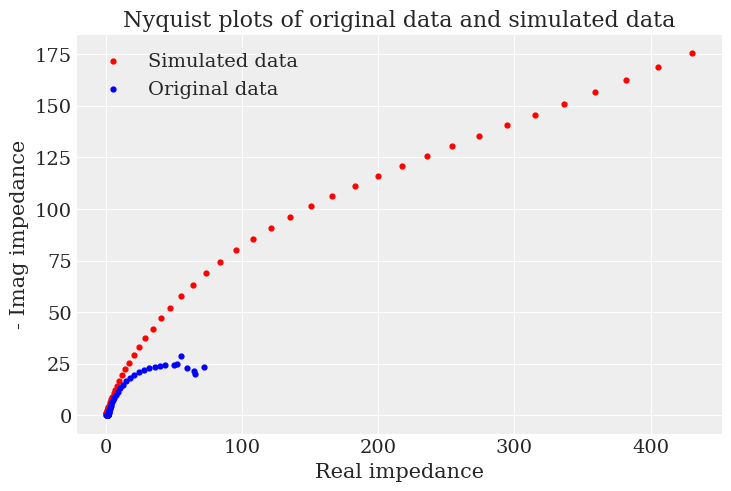

sample: 100%|█| 11000/11000 [00:31<00:00, 345.84it/s, 31 steps of size 3.05e-02.


1956.4600423704833
[P1-P2,P3]:Prior distributions with trajectories


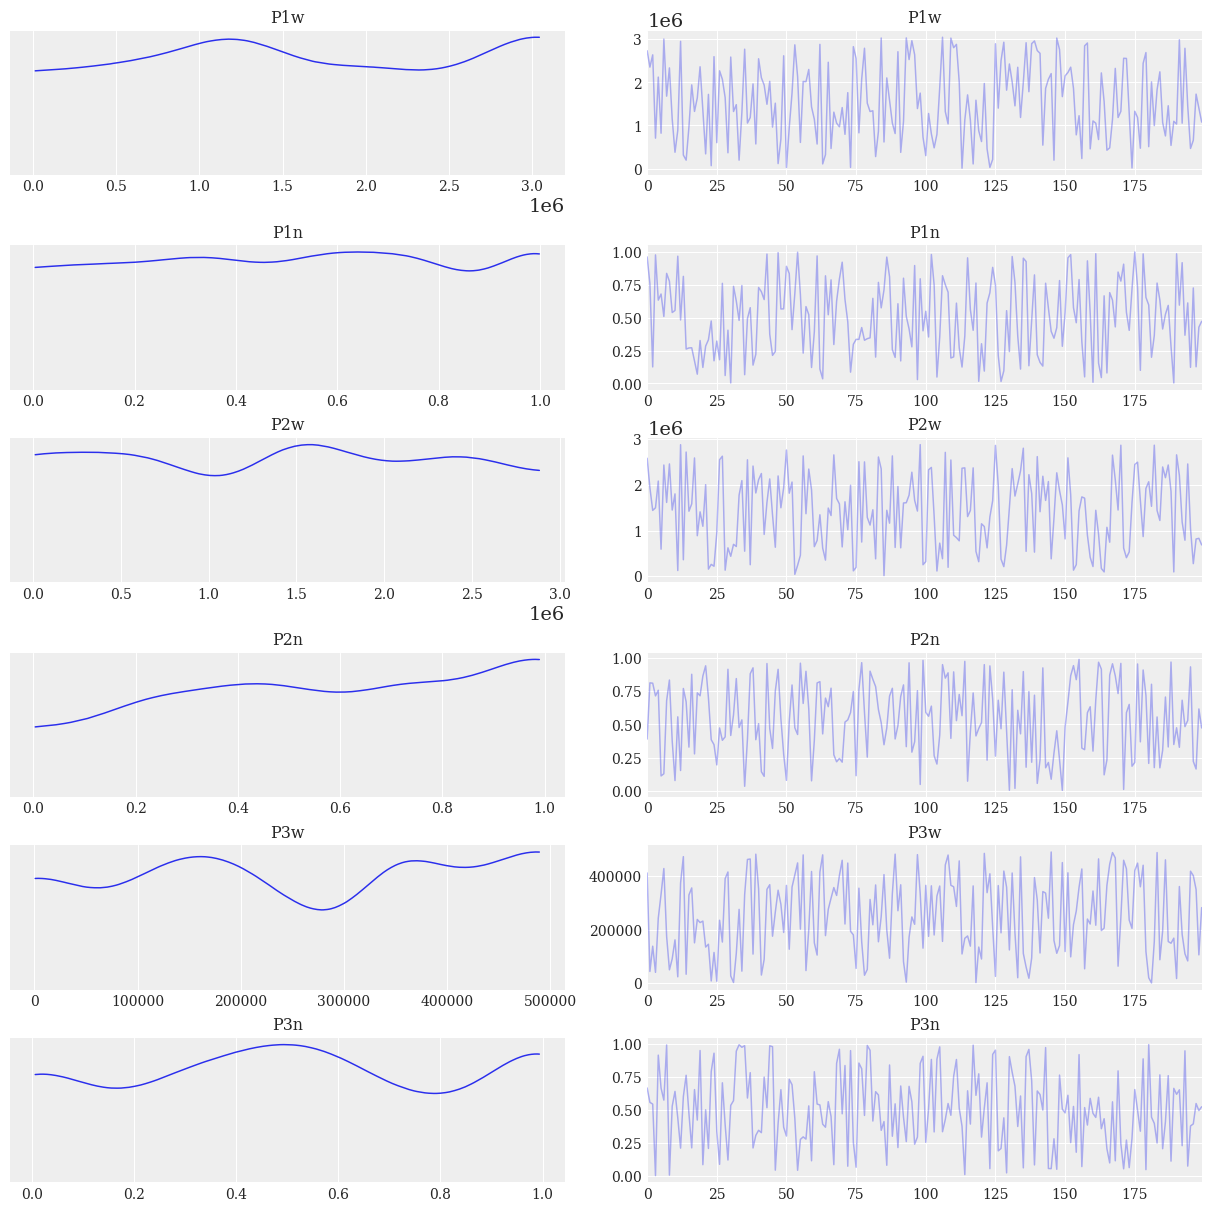

[P1-P2,P3]:Prior prediction


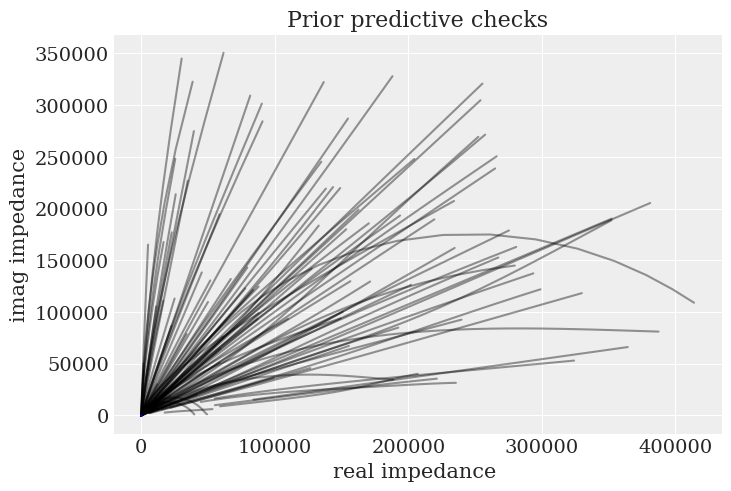

[P1-P2,P3]:Posterior distributions with HDI


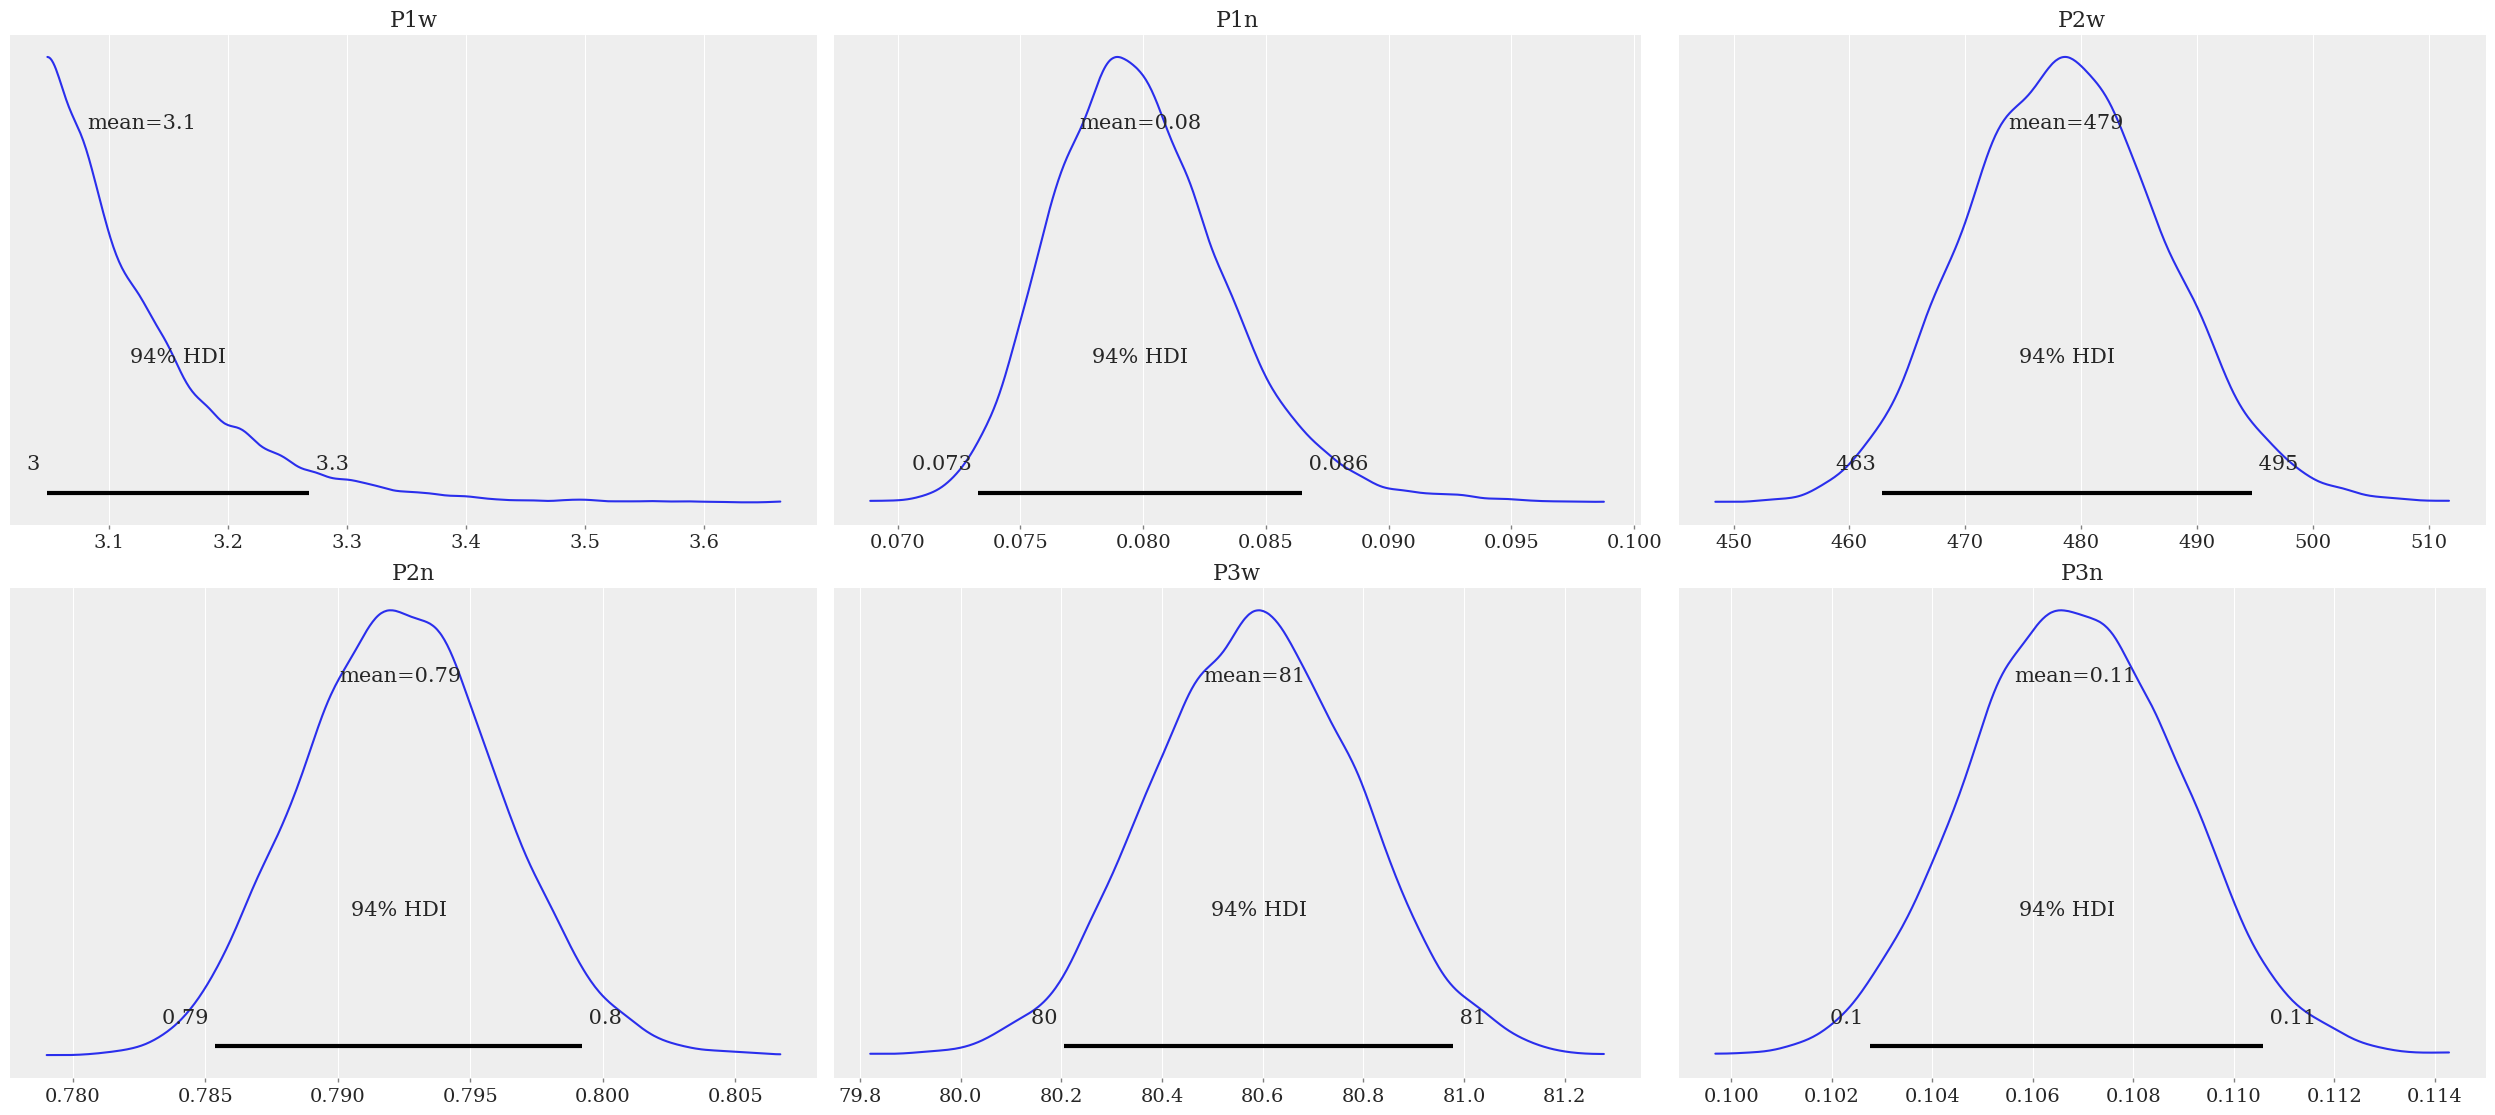

[P1-P2,P3]:Posterior distributions with trajectories


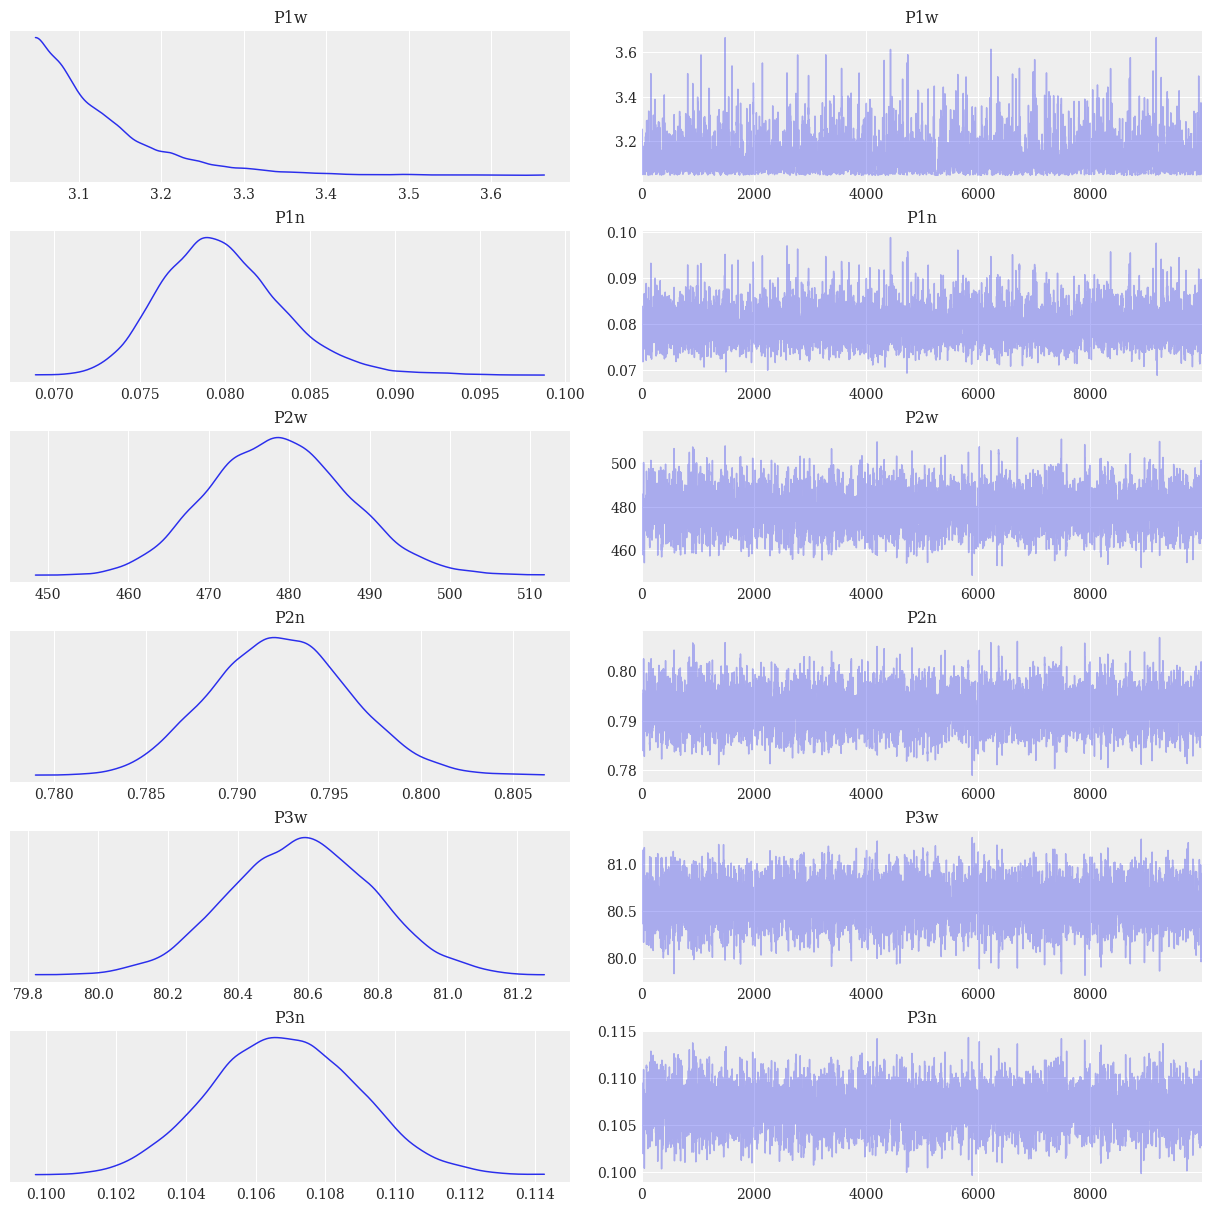

[P1-P2,P3]:Posterior predictions - real part
Posterior real part's fit: MSE = 0.23145344257354736; R2 = 0.9994410826946922


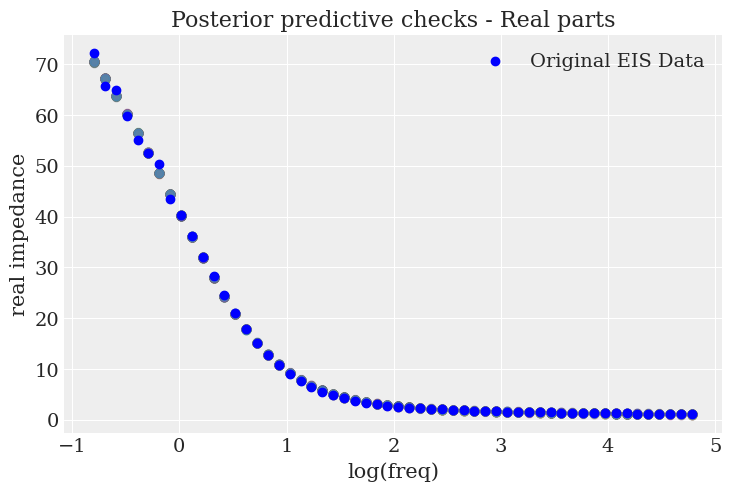

[P1-P2,P3]:Posterior predictions imag
Posterior imag part's fit: MSE = 0.6602763789892196; R2 = 0.9928378094780419


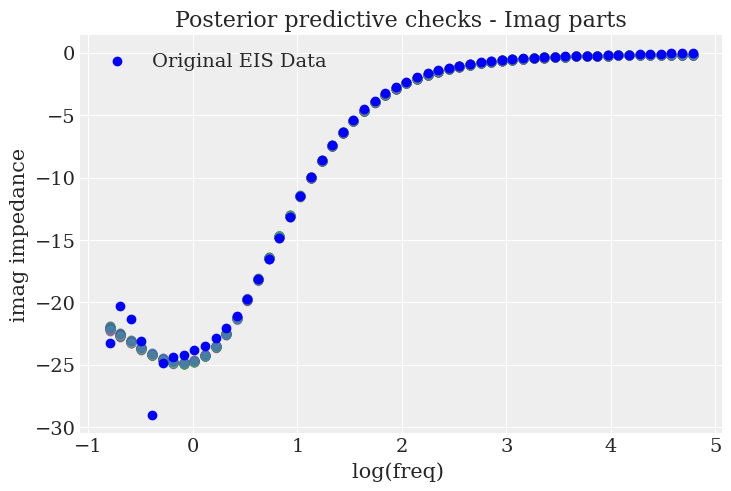

[P1-P2,P3]:Posterior predictions
Posterior fit: MSE = 0.891729821562767; R2 = 0.9982387306580628


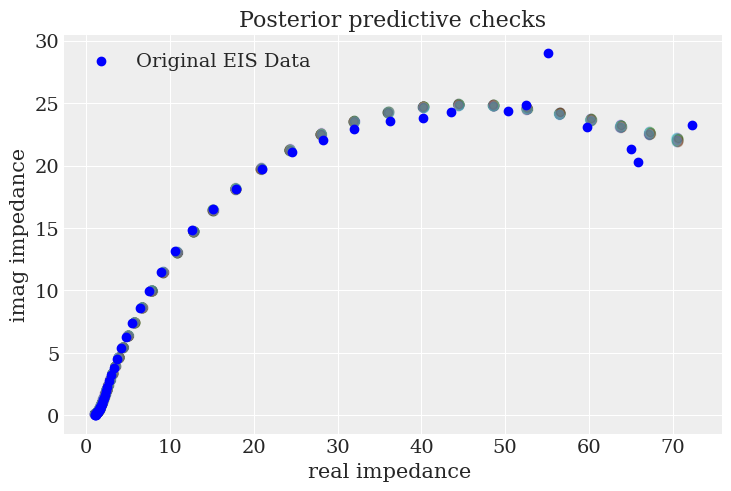

Circuit 1:P1-L2-[P3,P4] composed of components (['P1w', 'P1n', 'L2', 'P3w', 'P3n', 'P4w', 'P4n']) with values ([5.2712, 0.12652, 7.2356e-07, 1266.5, 0.99932, 72.031, 0.23862])
Julia circuit's fitting
r2_value:0.9905789815176997
r2_real_part:0.9970458917255873
r2_imag_part:0.9615298613721435
MSE_value:4.769856929779053
RMSE_value:2.1840002128614944


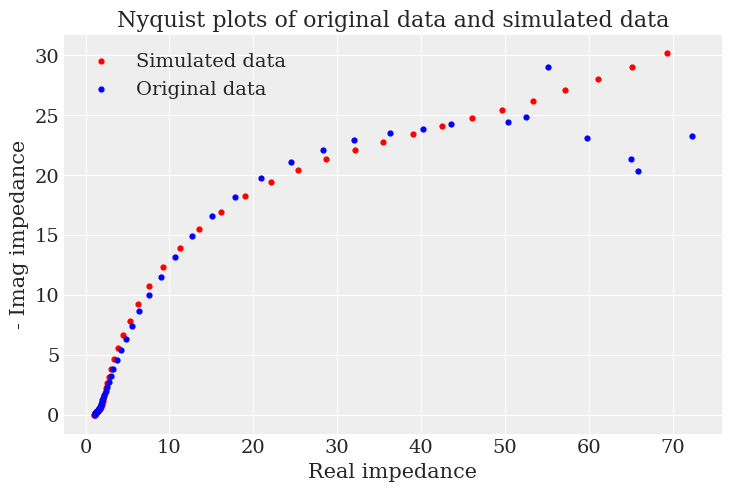

sample: 100%|█| 11000/11000 [01:36<00:00, 114.26it/s, 767 steps of size 1.67e-03


1963.2022340442054
P1-L2-[P3,P4]:Prior distributions with trajectories


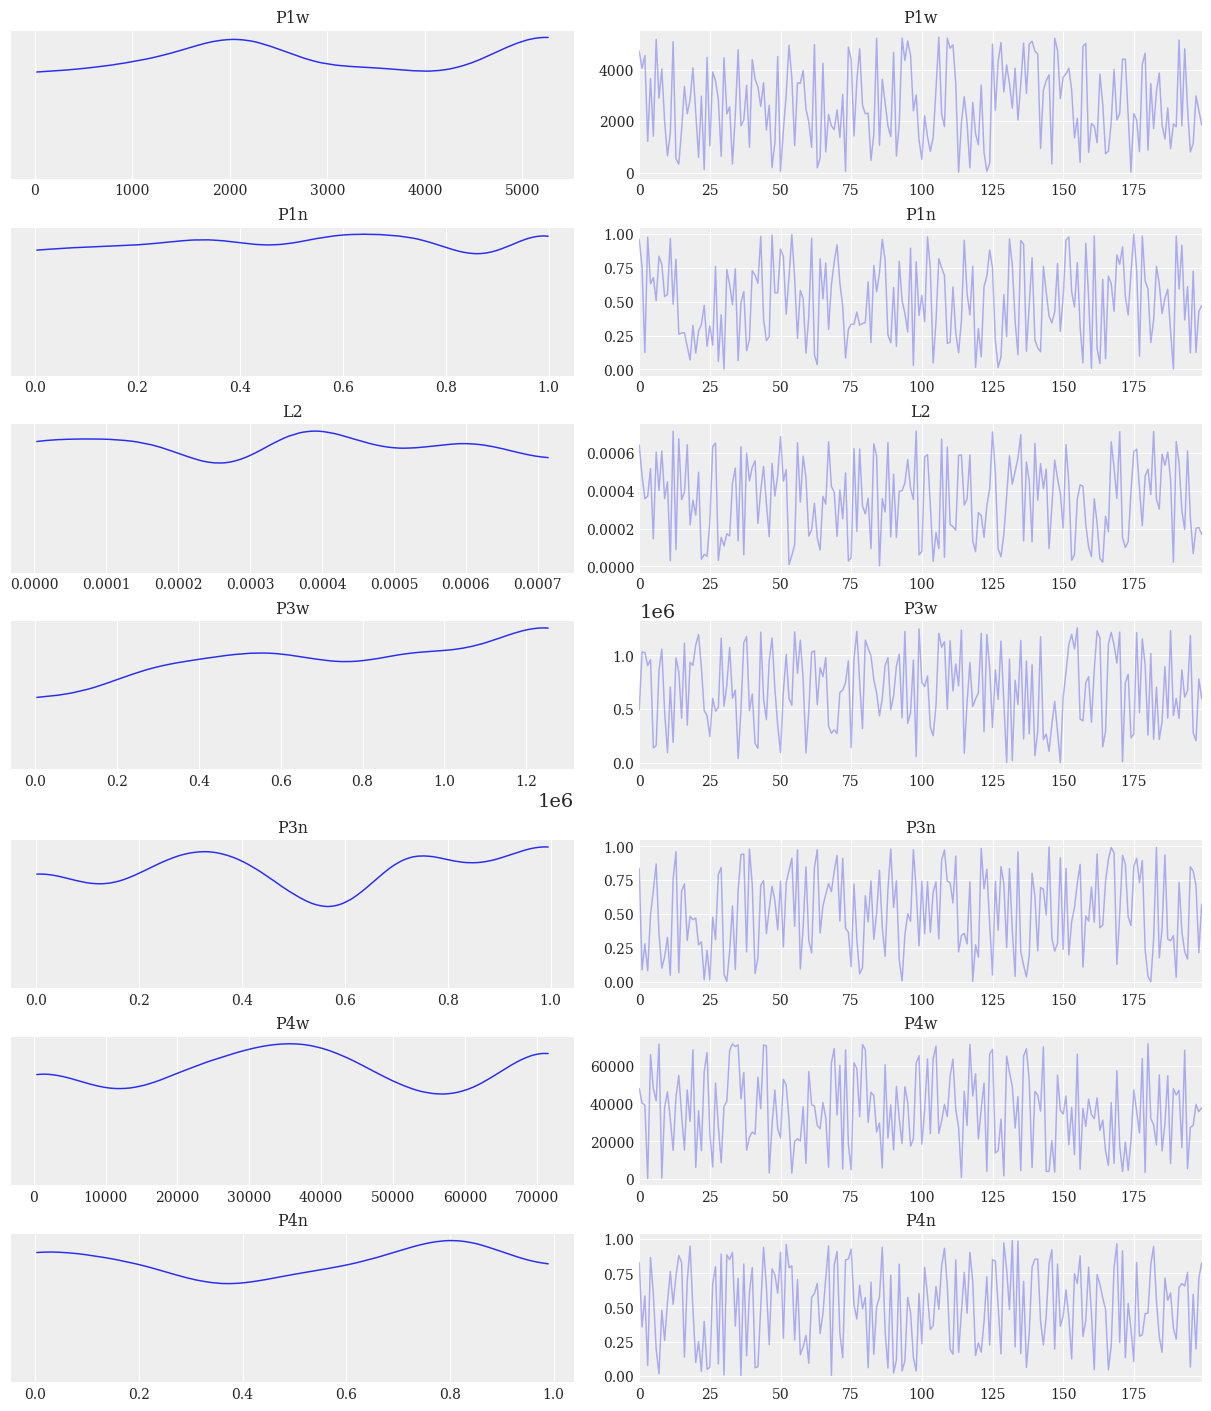

P1-L2-[P3,P4]:Prior prediction


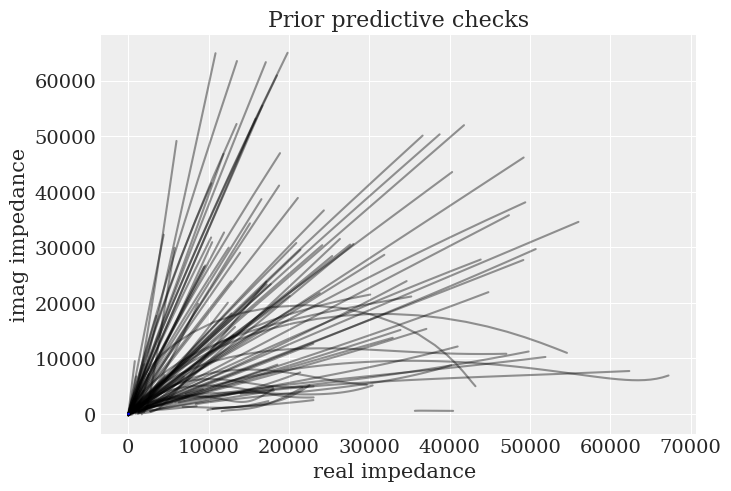

P1-L2-[P3,P4]:Posterior distributions with HDI


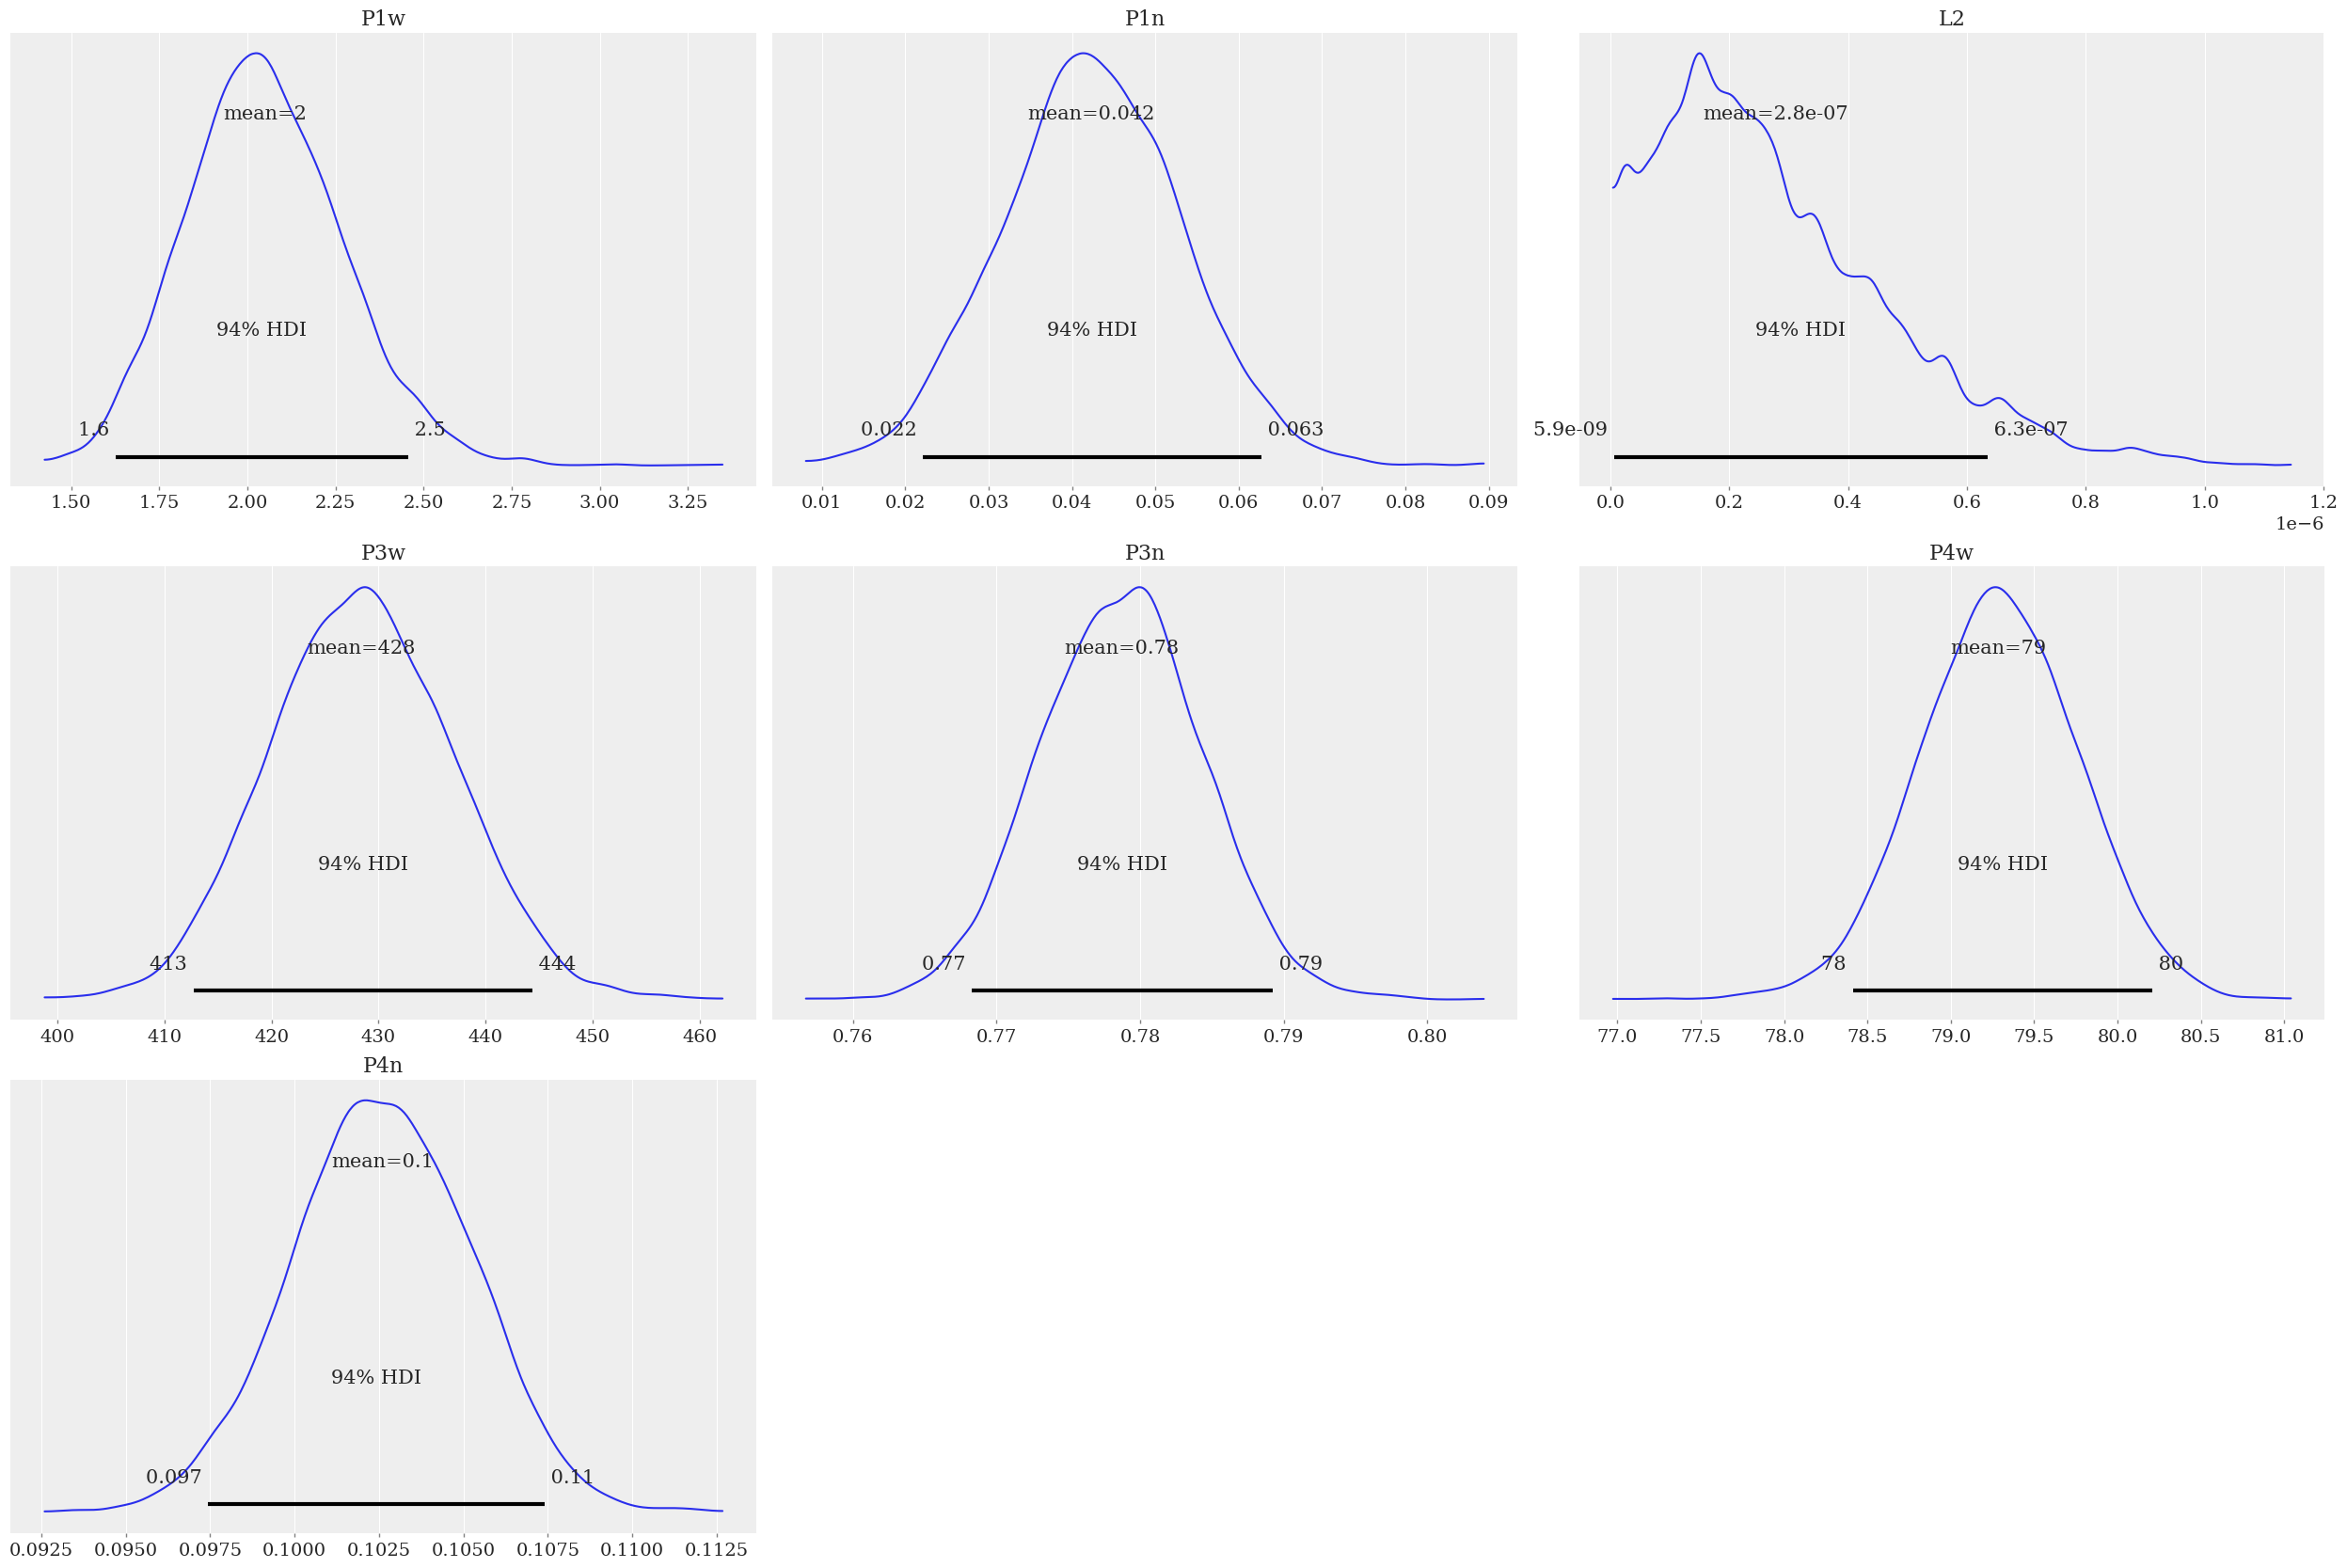

P1-L2-[P3,P4]:Posterior distributions with trajectories


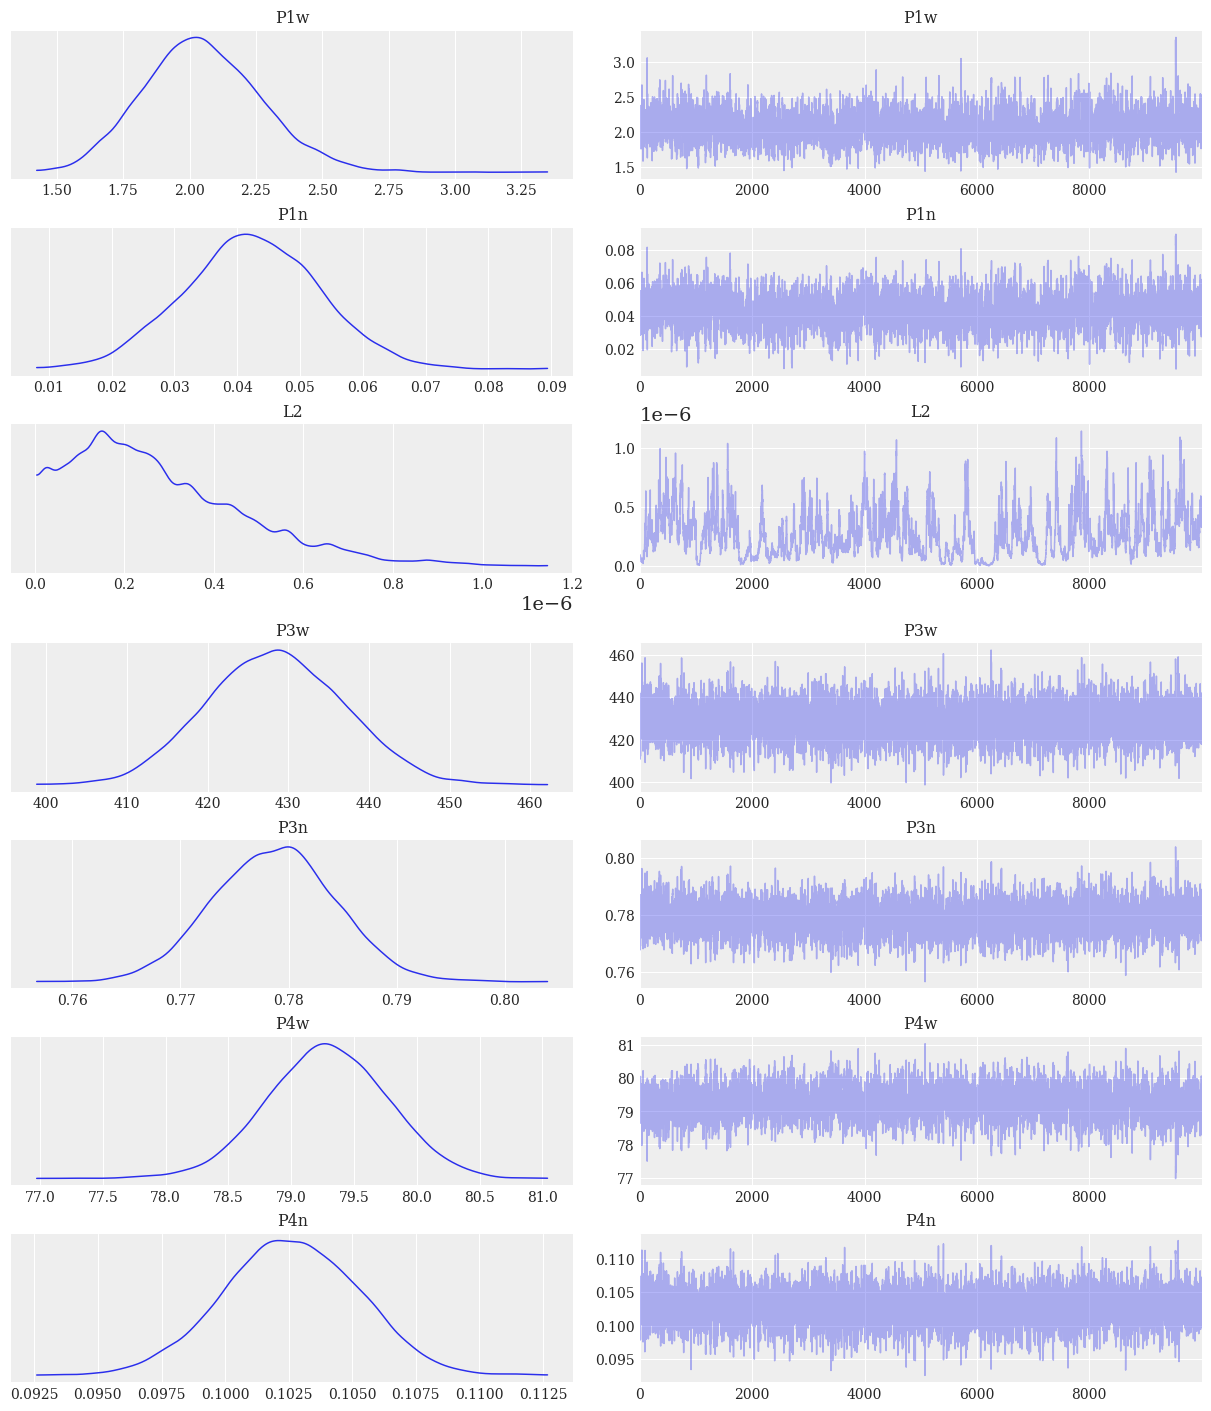

P1-L2-[P3,P4]:Posterior predictions - real part
Posterior real part's fit: MSE = 0.23018325760960578; R2 = 0.9994441499556501


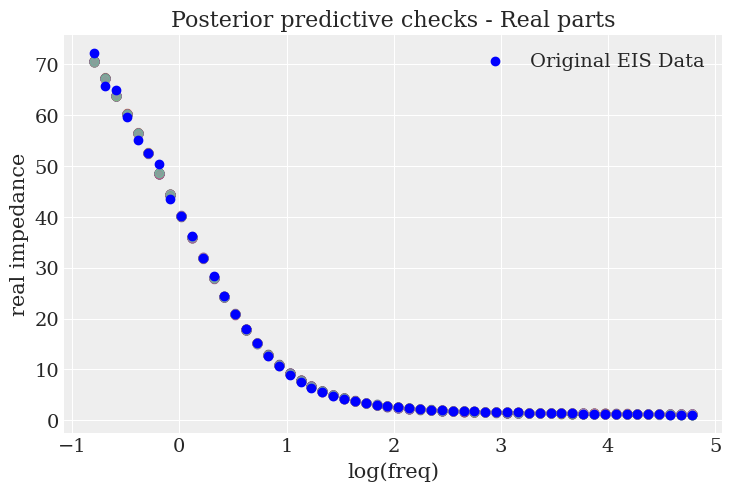

P1-L2-[P3,P4]:Posterior predictions imag
Posterior imag part's fit: MSE = 0.6540832644701005; R2 = 0.9929049878418554


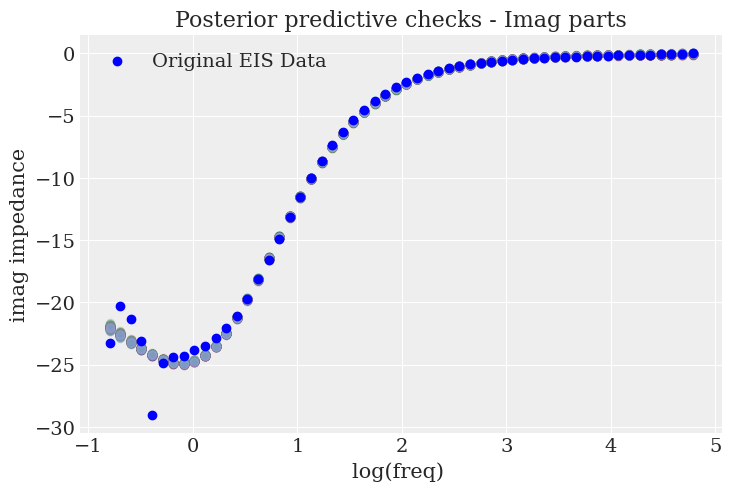

P1-L2-[P3,P4]:Posterior predictions
Posterior fit: MSE = 0.8842665153741837; R2 = 0.9982534715476835


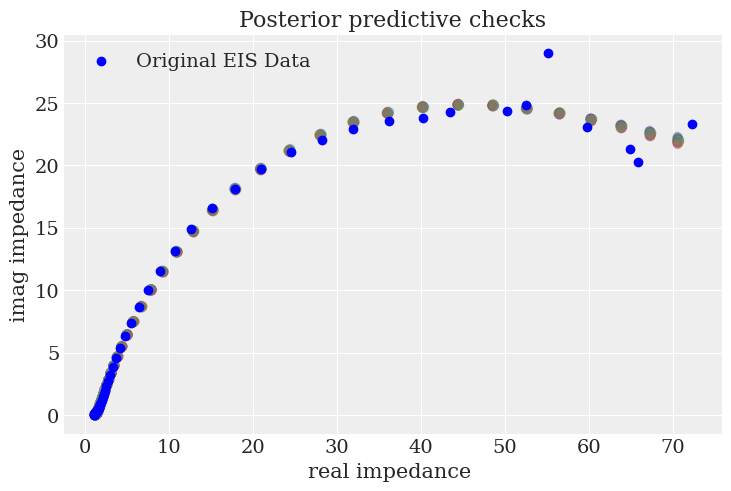

In [69]:
results = Bayesian_inference(data = data_processed, data_path = data_path, df = new_df,n_control=0.2)

### Results

In [70]:
results

,Combined Circuits,Combined Values,Mathematical expressions,Counts,Different value sets,Variables_names,Variables_values,ECM Data,R_square,Mean Square Error,...,BI_models_description,Priors_prediction,Posterior_prediction,AIC Value,Posterior_mean_r2,Posterior_mean_mse,Posterior_mean_r2_real,Posterior_mean_mse_real,Posterior_mean_r2_imag,Posterior_mean_mse_imag
0,"[P1-P2,P3]","[[P1w = 3047.2, P1n = 0.76181, P2w = 2918.2, P...",((X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1...,1,1,"[P1w, P1n, P2w, P2n, P3w, P3n]","[3047.2, 0.76181, 2918.2, 0.72954, 491.66, 0.2...","[(0.1666009-0.3797925j), (0.19845296-0.4510268...",-42.067494,21805.050781,...,<bound method MCMC.print_summary of <numpyro.i...,"{'P1n': [0.96243346, 0.75821376, 0.12518907, 0...","{'P1n': [0.07596322, 0.07942283, 0.08163349, 0...",1956.460042,0.998239,0.891730,0.999441,0.231453,0.992838,0.660276
1,"P1-L2-[P3,P4]","[[P1w = 5.2712, P1n = 0.12652, L2 = 7.2356e-07...",X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1])...,1,1,"[P1w, P1n, L2, P3w, P3n, P4w, P4n]","[5.2712, 0.12652, 7.2356e-07, 1266.5, 0.99932,...","[(1.016716+0.06746421j), (1.0472168+0.00303019...",0.990579,4.769857,...,<bound method MCMC.print_summary of <numpyro.i...,"{'L2': [0.00064091076, 0.00047973354, 0.000357...","{'L2': [7.3603196e-08, 7.358166e-08, 9.823254e...",1963.202234,0.998253,0.884267,0.999444,0.230183,0.992905,0.654083


### Results loading part

In [80]:
data_path = "1-mea_3_04_peis_c01.xlsx_results.pkl"

with open(data_path, 'rb') as f:
    data = dill.load(f)


In [83]:
results_df = pd.DataFrame(data)
results_df

,Combined Circuits,Combined Values,Mathematical expressions,Counts,Different value sets,Variables_names,Variables_values,ECM Data,R_square,Mean Square Error,...,BI_models_description,Priors_prediction,Posterior_prediction,AIC Value,Posterior_mean_r2,Posterior_mean_mse,Posterior_mean_r2_real,Posterior_mean_mse_real,Posterior_mean_r2_imag,Posterior_mean_mse_imag
0,"[P1-P2,P3]","[[P1w = 3047.2, P1n = 0.76181, P2w = 2918.2, P...",((X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1...,1,1,"[P1w, P1n, P2w, P2n, P3w, P3n]","[3047.2, 0.76181, 2918.2, 0.72954, 491.66, 0.2...","[(0.1666009-0.3797925j), (0.19845296-0.4510268...",-42.067494,21805.050781,...,<bound method print_summary of <numpyro.infer....,"{'P1n': [0.96243346, 0.75821376, 0.12518907, 0...","{'P1n': [0.07596322, 0.07942283, 0.08163349, 0...",1956.460042,0.998239,0.891730,0.999441,0.231453,0.992838,0.660276
1,"P1-L2-[P3,P4]","[[P1w = 5.2712, P1n = 0.12652, L2 = 7.2356e-07...",X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1])...,1,1,"[P1w, P1n, L2, P3w, P3n, P4w, P4n]","[5.2712, 0.12652, 7.2356e-07, 1266.5, 0.99932,...","[(1.016716+0.06746421j), (1.0472168+0.00303019...",0.990579,4.769857,...,<bound method print_summary of <numpyro.infer....,"{'L2': [0.00064091076, 0.00047973354, 0.000357...","{'L2': [7.3603196e-08, 7.358166e-08, 9.823254e...",1963.202234,0.998253,0.884267,0.999444,0.230183,0.992905,0.654083


In [1]:
#end